# Predicting Wine Quality


## Overview
In this notebook we will be using a modified version of the wine quality data set from the UCI machine learning repository and performing logistic regression using forward stepwise, ridge and LASSO regularisation.

In [1]:
#prevent scroll boxes for individual notebook cells
IRdisplay::display_javascript('IPython.OutputArea.auto_scroll_threshold = 99999;')
# set initial plot size
options(repr.plot.width=5, repr.plot.height=3)
# set seed so the results using random sampling are reproducible
set.seed(1234)

## Libraries
Load the required libraries.
* ggplot will be used for plotting
* reshape will be used to transorm and modify data frames for plotting
* glmnet will be used for LASSO and ridge penalization
* moments will be used for detailed statistics about the data sets
* caret will be used for building confusion matrices
* ROCR will be used for ROC curves and calculating area under them (AUC)
* plotmo will be used to extend the plotting function of glmnet

In [2]:
# setwd("C:/Users/Tim/Downloads/Data Science/FIT5149 - Applied data science")
# setwd("C:/Users/tric0003/Downloads")

#install the required libraries
#install.packages("ggplot2", repos='http://cran.us.r-project.org')
#install.packages("reshape", repos='http://cran.us.r-project.org')
#install.packages("glmnet", repos='http://cran.us.r-project.org')
#install.packages("caret", repos='http://cran.us.r-project.org')
#install.packages("ROCR", repos='http://cran.us.r-project.org')
#install.packages("plotmo", repos='http://cran.us.r-project.org')


library(ggplot2)
library(reshape)
library(glmnet)
library(moments)
library(caret)
library(ROCR)
library(plotmo)


Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'reshape' was built under R version 3.3.3"Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:reshape':

    expand

Loading required package: foreach
Loaded glmnet 2.0-5

Warning message:
"package 'moments' was built under R version 3.3.2"Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Warning message:
"package 'ROCR' was built under R version 3.3.3"Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.3.3"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
"package 'plotmo' was built under R version 3.3.3"Loading required package: plotrix
Warning message:
"package 'plotrix' was built under R version 3.3.3"
Attaching package: 'plotrix'

The following object is masked from 'package:gplo

## Wine data set
We will begin by loading the training data set, taking a look at its structure and checking whether there are any NA values in the data.

In [3]:
# load the trainng file
train = read.csv("Wine_training_dataset_2017.csv")
train = as.data.frame(train)
head(train)

sapply(train,function(x) sum(is.na(x)))

sapply(train, function(x) length(unique(x)))

summary(train)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.0,0.27,0.36,20.70,0.045,45,170,1.0010,3.00,0.45,8.8,good
6.3,0.30,0.34,1.60,0.049,14,132,0.9940,3.30,0.49,9.5,good
7.2,0.23,0.32,8.50,0.058,47,186,0.9956,3.19,0.40,9.9,good
8.1,0.28,0.40,6.90,0.050,30,97,0.9951,3.26,0.44,10.1,good
6.2,0.32,0.16,7.00,0.045,30,136,0.9949,3.18,0.47,9.6,good
8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,bad


fixed.acidity     volatile.acidity          citric.acid 
                   0                    0                    0 
      residual.sugar            chlorides  free.sulfur.dioxide 
                   0                    0                    0 
total.sulfur.dioxide              density                   pH 
                   0                    0                    0 
           sulphates              alcohol              quality 
                   0                    0                    0

fixed.acidity     volatile.acidity          citric.acid 
                  65                  116                   87 
      residual.sugar            chlorides  free.sulfur.dioxide 
                 303                  150                  125 
total.sulfur.dioxide              density                   pH 
                 246                  829                  102 
           sulphates              alcohol              quality 
                  77                   96                    2

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 4.800  
 Mean   : 6.852   Mean   :0.2803   Mean   :0.3357   Mean   : 6.031  
 3rd Qu.: 7.300   3rd Qu.:0.3275   3rd Qu.:0.3900   3rd Qu.: 9.000  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00      1st Qu.:107.0        1st Qu.:0.9917  
 Median :0.04300   Median : 33.00      Median :133.0        Median :0.9936  
 Mean   :0.04604   Mean   : 35.05      Mean   :137.7        Mean   :0.9938  
 3rd Qu.:0.05000   3rd Qu.: 45.00      3rd Qu.:166.0        3rd Qu.:0.9958  
 Max.   :0.34600   Max.   :289.00      Max.   :440.0   

We can see from the results that the data set is made up of 12 variables:
* fixed.acidity - numerical value ranging from 3.8 to 14.2
* volatile.acidity - numerical value ranging from 0.08 to 1.1
* citric.acid - numerical value ranging from 0.0 to 1.66
* residual.sugar - numerical value ranging from 0.6 to 65.8
* chlorides - numerical value ranging from 0.009 o 0.346
* free.sulfur.dioxide - numerical value ranging from 2.0 to 289.0
* total.sulfur.dioxide - numerical value ranging from 9.0 to 440.0
* density - numerical value ranging from 0.9871 to 1.039
* pH - numerical value ranging from 2.72 to 3.82
* sulphates - numerical value ranging from 0.22 to 1.08
* alcohol - numerical value ranging from 8.4 to 14.0
* quality - categorical value - good or bad, 2178 have been classified as good while 1105 have been classified as bad (an approximately 2/3 to 1/3 split)

Our check for NA values have shown that there are values for every feature and every row.

In [4]:
str(train)

'data.frame':	3283 obs. of  12 variables:
 $ fixed.acidity       : num  7 6.3 7.2 8.1 6.2 8.1 7.9 6.6 8.3 6.6 ...
 $ volatile.acidity    : num  0.27 0.3 0.23 0.28 0.32 0.27 0.18 0.16 0.42 0.17 ...
 $ citric.acid         : num  0.36 0.34 0.32 0.4 0.16 0.41 0.37 0.4 0.62 0.38 ...
 $ residual.sugar      : num  20.7 1.6 8.5 6.9 7 ...
 $ chlorides           : num  0.045 0.049 0.058 0.05 0.045 0.033 0.04 0.044 0.04 0.032 ...
 $ free.sulfur.dioxide : num  45 14 47 30 30 11 16 48 41 28 ...
 $ total.sulfur.dioxide: num  170 132 186 97 136 63 75 143 172 112 ...
 $ density             : num  1.001 0.994 0.996 0.995 0.995 ...
 $ pH                  : num  3 3.3 3.19 3.26 3.18 2.99 3.18 3.54 2.98 3.25 ...
 $ sulphates           : num  0.45 0.49 0.4 0.44 0.47 0.56 0.63 0.52 0.67 0.55 ...
 $ alcohol             : num  8.8 9.5 9.9 10.1 9.6 12 10.8 12.4 9.7 11.4 ...
 $ quality             : Factor w/ 2 levels "bad","good": 2 2 2 2 2 1 1 2 1 2 ...


The str function provides a description of the variables types which confirm the assumptions made previously about each feature type (numerical or categorical)

## Graphical Exploration of Data
For each of the predictive features:
* fixed.acidity
* volatile.acidity
* citric.acidity
* residual.sugar
* chlorides
* free.sulfur.dioxide
* total.sulfur.dioxide
* density
* pH
* suplhates
* alcohol

We will look at the density plots for each of the predictive variables. A density plot is similar to a histogram but has been modified with a smoother and in this case plots the density rather than a raw count of the frequency to normalize any difference in the class probabilities (e.g. only ~33% of the wines are classified as bad so by looking at the density we eliminate the effect that this would have on the count numbers). The density plot shows the distribution of the data over various values of the feature. In these plots we have overlayed the data for class = good and class = bad so we can identify any distribution differences between the classes for each feature. This allows us to visually identify which features might have good predictive power. It is imporant to note that we are looking at the distribution of the data controlling only for class quality, once a feature is added the next feature found is the one that adds the next most value in identifying the class and is dependent on what is already 'known' due to the feature(s) added earlier.

### Fixed Acidity

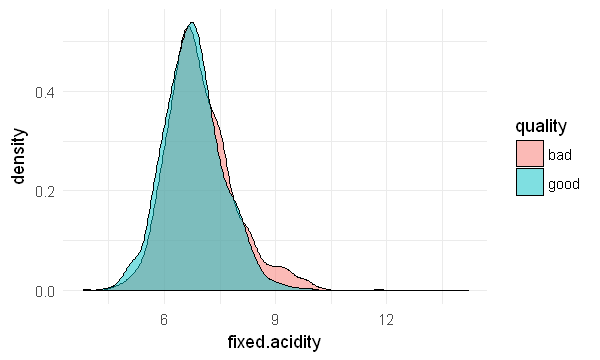

In [5]:
ggplot(train, aes(x=fixed.acidity, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

The distribution of both classes are similar with means ~7. There is however an area in the upper tail (where fixed.acidity is greater than or equal to 9) where a wine is more likely to be bad than good.

### Volatile Acidity

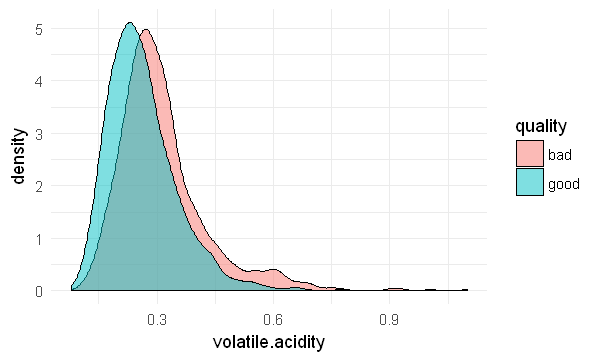

In [6]:
ggplot(train, aes(x=volatile.acidity, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

Volatile acididty for each of the classes displays a difference in mean and shows higher volatile acidity levels mean the wine is more likely to be classified as bad.

### Citric Acid

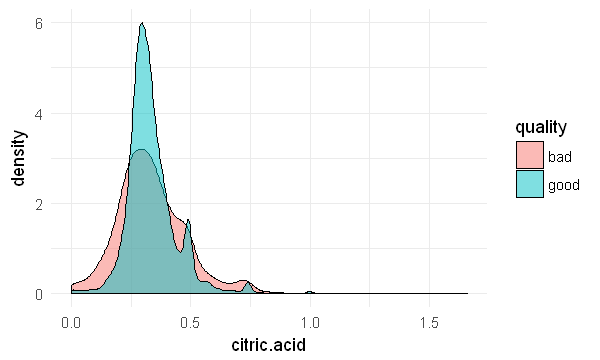

In [7]:
ggplot(train, aes(x=citric.acid, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

While the density plots look quite different the means of both classes look to be very similar and both are 'reasonably' symmetric about the same mean.

### Residual Sugar

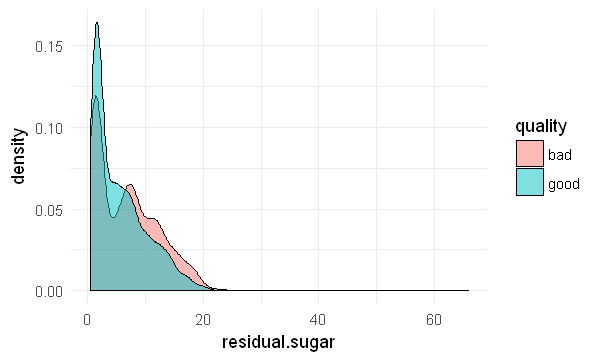

In [8]:
ggplot(train, aes(x=residual.sugar, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

The density plot shows that residual sugar is not very normally distributed with large skews to the right for both classes. It also that a wine with higher residual sugar is more likely to be classified as bad.

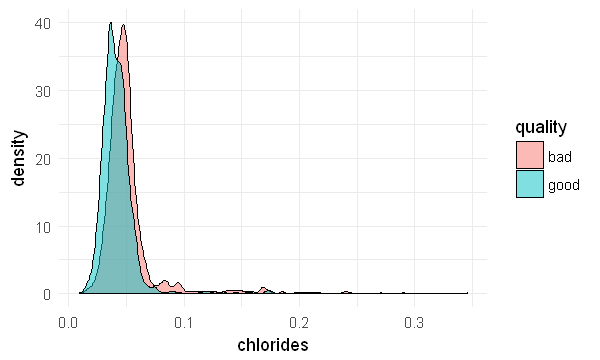

In [9]:
ggplot(train, aes(x=chlorides, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

Both classes show high levels of peakedness and a skewness to the right. There is also a difference in the means with higher chlorides more likely to lead to a bad quality wine.

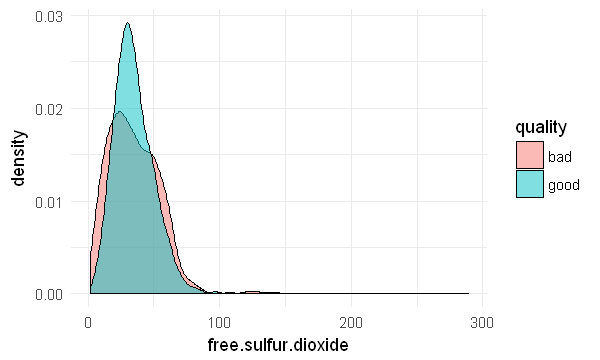

In [10]:
ggplot(train, aes(x=free.sulfur.dioxide, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

Both classes have similar means and both are skewed moderately to the right, i.e. the distribution of each class is very similar.

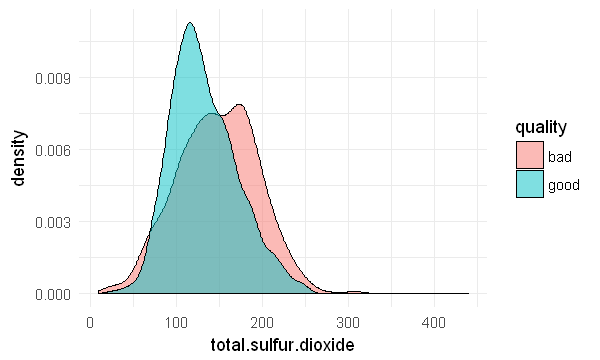

In [11]:
ggplot(train, aes(x=total.sulfur.dioxide, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

The means of each class are different with higher total.sulfur.dioxide likely to lead to a bad quality wine.

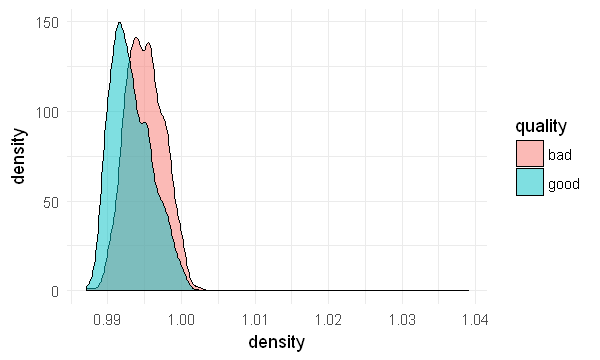

In [12]:
ggplot(train, aes(x=density, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

There is a difference in the mean of each class and a higher density wine is more likely to be a bad quality wine.

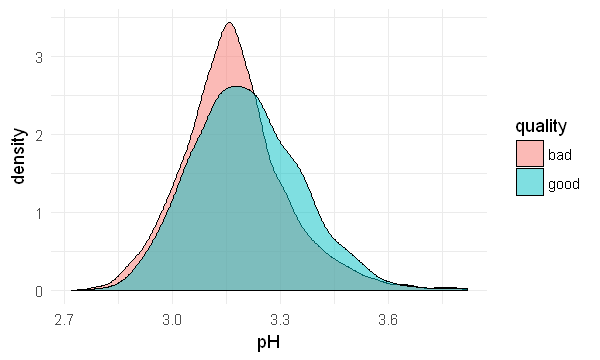

In [13]:
ggplot(train, aes(x=pH, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

The means are quite similar but the distribution of for good wines is not as symmetrical and higher pH wines are more likely to be good quality.

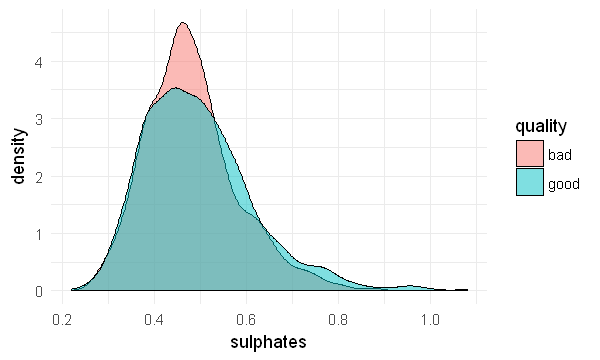

In [14]:
ggplot(train, aes(x=sulphates, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

The means look to be very similar with very similar right skewed distributions.

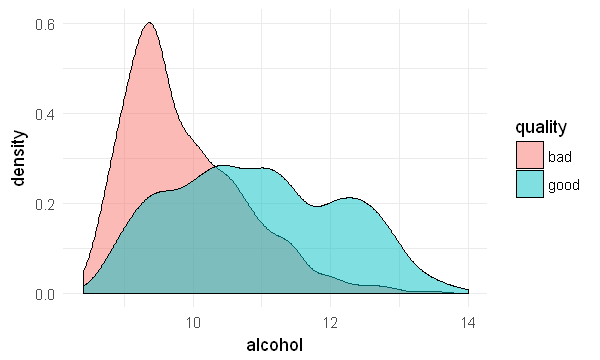

In [15]:
ggplot(train, aes(x=alcohol, fill=quality)) + geom_density(alpha = 0.5) + theme_minimal()

The means are quite different and a lower alcohol wine is more likely to be classified as bad. This feature shows the most class separation from a disribution point of view.

## Further note on class separation by distribution

In the density plots we have seen that alcohol shows the most class separation by distribution. We have also seen that density also shows strong class distribution. However these two features are related, alcohol has a lower density than water so low alcohol wines would likely have a higher density. This means these two features may be telling us similar information. In a stepwise algorithm once we add alcohol (or density) the other feature may now add less value.

# Model Creation

### Forward Stepwise Selection
The forward stepwise selection algortihm begins with the starting model containing just the intercept. In each step of the algorithm the 'best' feature is selected and added to the model. We will use four different measures in order to identify the 'best' feature at each step:
* Area Under the Curve (AUC)
* Akaike Information Criterion
* Bayesian Information Criterion
* F-Measure

### Area Under the Curve (AUC)
Area under the curve refers to the area under the receiver operating charactersitic (ROC) curve. The curve plots the true postivie rate against the false positive rate at different cutoffs. The ideal ROC curve is a veritical line up to 1 on the true positive rate axis (vertical axis) before turning horizontal and running to 1,1 which indicates the model correctly predicted all of the true positives before getting any wrong. This ideal curve has an area of 1. In contrast picking using only information known about the number of each class (eg. in this data set 2/3 are good, 1/3 are bad quality) would lead to a diagonal line running from 0,0 to 1,1 with an area under the curve of 0.5. Therefore when selecting features using the AUC as the measure we will select the feature that leads to the highest AUC.

### Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)
Both of the information criteria measures compare the quality of one model with another. Both AIC and BIC penalises the complexity of the model and will only accept a model with additonal features if it increases the accuracy of the model enough to counteract that penalty. BIC introduces a larger penalty per parameter in the model so you can expect the resulting model to be less complex in comparison with AIC.

### F-Measure
F-Measure (or F-1 measure) is a accuracy score that takes into account the precision and the recall of a model. Precision is defined as the number of correctly classified positives (true postive) / total number classfiied as positive. Recall is defined as the number of correctly classified postives (true postive) / total number of true positives. The issue with both of these measures is that one can be manipulated at the expense of the other. The F-Measure tries to correct this, it can never be higher than the precision OR the recall and forces a compromise between the two. F- measure is calcuated by: <br>
<b> 2 * precision * recall / (precision + recall) </b>

## Helper Functions
The following functions will be used in the creation of the models.

### folds function
The folds function takes a data set and the number of required folds as input and returns a list the length of the number of required folds, each item in the list holds a set of training and a set of test data for that fold.

In [16]:
folds <- function(data, k = 10) {
  #shuffle the data
  dataShuffled <- data[sample(nrow(data)),]
  
  #Create k  folds
  folds <- cut(seq(1,nrow(dataShuffled)),breaks=k,labels=FALSE)
  
  testData <- list()
  trainData <- list()
  
  for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData[[i]] <- dataShuffled[testIndexes, ]
    trainData[[i]] <- dataShuffled[-testIndexes, ]
  }
  
  return(list('training' = trainData, 'testing' = testData))
}



train$quality <- ifelse(train$quality == 'good', 1, 0)


### fMeasure function
The fMeasure function takes a vector of predictions and the vector of actual labels and returns the F-Measure score.

In [17]:
fMeasure <- function(predictions, data.label){
    precision <- sum(predictions & data.label) / sum(predictions)
    recall <- sum(predictions & data.label) / sum(data.label)
    fmeasure <- 2 * precision * recall / (precision + recall)

    return(fmeasure)
}

### plotROC function
The plotROC function takes a list of searchFeatures, the predictions data frame and the cross validation data folds (containing the actual test labels) and plots the receiver operating characteristics of each of the features on a single plot.

In [18]:
plotROC <- function(searchFeatures, predictions, dataFolds) {
     colors <- c('red', 'blue', 'green', 'yellow', 'gray', 'pink', 'orange', 'black', 'brown2', 'blueviolet', 'darkgreen', 'darkseagreen') #colors
for (i in 1:length(searchFeatures)) {
            plot(performance(prediction(predictions[,i],dataFolds$testing[[2]]$quality),"tpr","fpr"), add=(i!=1),col=colors[i], lwd=2)
            legend(0.55, 0.55, legend=searchFeatures, col=colors, lwd = 2, cex=0.8)    
        }
}

### plotXIC function
The plotXIC function takes the data frame containing a set of features and the models corresponding score (AIC or BIC score) for if they were added to the model. It plots the score of each feature in a bar chart.

In [19]:
plotXIC <- function(auc_df) {
    measure <- auc_df[, 2]
    print(ggplot(aes(x = feature, y = measure), data = auc_df) 
          + geom_bar(stat="identity", color = 'skyblue', fill = 'skyblue', width = 0.075 * nrow(auc_df)) 
          + theme_minimal() + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)) + coord_cartesian(ylim = c(2800, 3800)))
    }

### plotfMeasure function
The plotfMeasure function takes the data frame containing a set of features and the models corresponding F-Measure score for if they were added to the model. It plots the score of each feature in a bar chart.

In [20]:
plotfMeasure <- function(auc_df) {
    measure <- auc_df[, 2]
    print(ggplot(aes(x = feature, y = measure), data = auc_df) 
          + geom_bar(stat="identity", color = 'skyblue', fill = 'skyblue', width = 0.075 * nrow(auc_df)) 
          + theme_minimal() + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)) + coord_cartesian(ylim = c(0.78, 0.83)))
    }

### aucMeasure, aicMeasure, bicMeasure and fmMeasure functions
The following functions all build models using forward stepwise selection but each model selects the feature to be added using a different measure. They could be combined into a single function however it would contain a lot of if statements and while overall would lead to less code would also lead to lower readablity.


<u>aucMeasure function</u><br>
The aucMeasure function will be explained as an example. The function takes the training data, the target variable (class) and the number of folds for CV testing and the maximum number of features for the model (should it the user wish to restrict the complexity of the model). For each of the features that are not already included in the model it uses CV testing to select (using AUC as the measure) the best feature to be added to the model. It continues this process until all features are used or the maximum number of features have been identified. For each loop of the feature selection it prints the ROC (receiver operating charactersitc curve) for the features being selected from as well as the score for each model if that feature was to be added. It shows the process of adding each feature to the model.

The function returns a list of the best model for each number of features (one through to max feature) as well as the correspodning AUC score for each model).

In [21]:
aucMeasure <- function(data, target, K = 10, formula = paste(target,' ~ 1 ', sep = ''), maxFeatures = ncol(data) - 1) {
  
    # set the labels
    train.labels <- train[(names(train) %in% target)]
    
    # remove the target column from the data
    train.data <- train[!(names(train) %in% target)]
  
    # complete list of predictor features in data
    features <- colnames(train.data)
  
    best_models <- data.frame(matrix(ncol = 3, nrow = 0))
    colnames(best_models) <- c("feature_count", "model", "AUC")
    j <- 0
    
    # create the k folds of data
    dataFolds <- folds(data, 10)
    
    # build the initial model using the comlete data set
    model <- glm(formula, family=binomial(link = 'logit'),data = data)
    # get the used features of this model
    usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])
    
    # while the number of used features is less than the maximum allowed features
    while (length(usedFeatures) < maxFeatures) {
    
        j <- j + 1
        # create an empty list to store the AUC score of each model with the potential new feature
        auc <- list()
        auc_df <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("feature", "AUC"))
        
        # create a list to store the cross validation scores for the model
        CVauc <- list()
        
        # for each fold in the folded data set get the current models AUC score
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            auc_measure <- performance(prediction(modelCV.prediction,test.labels), "auc")
            CVauc[k] <- auc_measure@y.values
        }
    
        # take the mean of the scores calculated abive
        current_AUC <- mean(as.numeric(CVauc))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent AUC is ', as.numeric(current_AUC))

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'AUC'] <- current_AUC
            
        # for each potential new feature calculate the mean AUC score across the data folds
        for (i in 1:length(searchFeatures)){
    
            formulaTest <- paste(c(formula, searchFeatures[i]), collapse = ' + ')
            
            CVauc <- list()
            modelCV.prediction <- list()
            modelCV.prediction.binary <- list()
            
            for (k in 1:K) {
                # set the testing labels
                test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
                # remove the target column from the test data
                test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
                modelCV <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
                modelCV.prediction[[k]] <- predict.glm(modelCV, newdata = test.data, type = 'response')
                modelCV.prediction.binary[[k]] <- ifelse(modelCV.prediction[[k]] > 0.5,1,0)
                auc_measure <- performance(prediction(modelCV.prediction[k],test.labels), "auc")
                CVauc[k] <- auc_measure@y.values
            }    
            
            auc_df[i,1] <- searchFeatures[i]
            auc_df[i,2] <- mean(as.numeric(CVauc))    
            
            auc[searchFeatures[i]] <- auc_df[i,2]
            
            # choose a k value (set to 2) and plot the example ROC curve
            model <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[2]])
            model.prediction <- predict.glm(modelCV, newdata = dataFolds$testing[[2]], type = 'response')
      
            if (i == 1) {
                  predictions <- data.frame(model.prediction)
            }
            else {
                predictions <- cbind(predictions, model.prediction)
            }   
            
        }
          
        # plot an example AUC curve
        plotROC(searchFeatures, predictions, dataFolds)
            
        # select the new predictor and build the formula
        newPredictor <- names(auc[order(unlist(auc),decreasing=TRUE) ][1])
        formula <- (paste(formula, newPredictor, sep = ' + '))
        
        # build a model using the new formula, get a list of the used features
        model <- glm(formula, family=binomial(link = 'logit'),data = train)
        usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])
        
        print((auc_df[with(auc_df, order(-AUC)), ]))     
      }
    
        # perform the AUC cross validation scoring one last time for the model where usedFeatures = maxFeatures
        auc <- list()
        
        CVauc <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            auc_measure <- performance(prediction(modelCV.prediction,test.labels), "auc")
            CVauc[k] <- auc_measure@y.values
        }
    
        current_AUC <- mean(as.numeric(CVauc))
        
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent AUC is ', as.numeric(current_AUC))

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'AUC'] <- current_AUC
    
    
  return(best_models)
}



In [22]:
aicMeasure <- function(data, target, K = 10, formula = paste(target,' ~ 1 ', sep = ''), maxFeatures = ncol(data) - 1) {
  
    # set the labels
    train.labels <- train[(names(train) %in% target)]
    
    # remove the target column from the data
    train.data <- train[!(names(train) %in% target)]
  
    # complete list of predictor features in data
    features <- colnames(train.data)
  
    colors <- c('red', 'blue', 'green', 'yellow', 'gray', 'pink', 'orange', 'black', 'brown2', 'blueviolet', 'darkgreen', 'darkseagreen') #colors
  
    best_models <- data.frame(matrix(ncol = 3, nrow = 0))
    colnames(best_models) <- c("feature_count", "model", "AIC")
    j <- 0
    
    dataFolds <- folds(data)
    
    model <- glm(formula, family=binomial(link = 'logit'),data = data)
    usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])
    
    while (length(usedFeatures) < maxFeatures) {
    
        j <- j + 1
    
        
        aic <- list()
        auc_df <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("feature", "AIC"))
        
        CVaic <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            
            CVaic[k] <- AIC(modelCV)
        }
    
        current_aic <- mean(as.numeric(CVaic))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent AIC is ', current_aic, '\n')

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'AIC'] <- current_aic
        
            
        for (i in 1:length(searchFeatures)){
            formulaTest <- paste(c(formula, searchFeatures[i]), collapse = ' + ')
            CVaic <- list()
            modelCV.prediction <- list()
            modelCV.prediction.binary <- list()
            
            for (k in 1:K) {
                # set the testing labels
                test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
                # remove the target column from the test data
                test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
                modelCV <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
                modelCV.prediction[[k]] <- predict.glm(modelCV, newdata = test.data, type = 'response')
                modelCV.prediction.binary[[k]] <- ifelse(modelCV.prediction[[k]] > 0.5,1,0)

                CVaic[k] <- AIC(modelCV)
                
            }
                
            # CHANGE TO STORE IN LIST AND LATER AVERAGE FOR EXISTING DATA FRAME
            auc_df[i,1] <- searchFeatures[i]
            auc_df[i,2] <- mean(as.numeric(CVaic))
            
            aic[searchFeatures[[i]]] <- auc_df[i,2]  
            
            model <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[5]])
        }         
  
        plotXIC(auc_df)
        
        newPredictor <- names(aic[order(unlist(aic),decreasing=FALSE) ][1])
        formula <- (paste(formula, newPredictor, sep = ' + '))
        model <- glm(formula, family=binomial(link = 'logit'),data = train)
        
        usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])

        print((auc_df[with(auc_df, order(AIC)), ]))
    }     
        
        CVaic <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            
            CVaic[k] <- AIC(modelCV)
        }
    
        current_aic <- mean(as.numeric(CVaic))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent AIC is ', current_aic, '\n')

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'AIC'] <- current_aic
    
  return(best_models)
}



In [23]:
bicMeasure <- function(data, target, K = 10, formula = paste(target,' ~ 1 ', sep = ''), maxFeatures = ncol(data) - 1) {
  
    # set the labels
    train.labels <- train[(names(train) %in% target)]
    
    # remove the target column from the data
    train.data <- train[!(names(train) %in% target)]
  
    # complete list of predictor features in data
    features <- colnames(train.data)
  
    colors <- c('red', 'blue', 'green', 'yellow', 'gray', 'pink', 'orange', 'black', 'brown2', 'blueviolet', 'darkgreen', 'darkseagreen') #colors
  
    best_models <- data.frame(matrix(ncol = 3, nrow = 0))
    colnames(best_models) <- c("feature_count", "model", "BIC")
    j <- 0
    
    dataFolds <- folds(data)
    
    model <- glm(formula, family=binomial(link = 'logit'),data = data)
    usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])
    
    while (length(usedFeatures) < maxFeatures) {
    
        j <- j + 1
    
        
        bic <- list()
        auc_df <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("feature", "BIC"))
        
        CVbic <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            
            CVbic[k] <- BIC(modelCV)
        }
    
        current_bic <- mean(as.numeric(CVbic))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent BIC is ', current_bic, '\n')

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'BIC'] <- current_bic
        
            
        for (i in 1:length(searchFeatures)){
            formulaTest <- paste(c(formula, searchFeatures[i]), collapse = ' + ')
            CVbic <- list()
            modelCV.prediction <- list()
            modelCV.prediction.binary <- list()
            
            for (k in 1:K) {
                # set the testing labels
                test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
                # remove the target column from the test data
                test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
                modelCV <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
                modelCV.prediction[[k]] <- predict.glm(modelCV, newdata = test.data, type = 'response')
                modelCV.prediction.binary[[k]] <- ifelse(modelCV.prediction[[k]] > 0.5,1,0)

                CVbic[k] <- BIC(modelCV)
                
            }
                
            # CHANGE TO STORE IN LIST AND LATER AVERAGE FOR EXISTING DATA FRAME
            auc_df[i,1] <- searchFeatures[i]
            auc_df[i,2] <- mean(as.numeric(CVbic))
            
            bic[searchFeatures[[i]]] <- auc_df[i,2]  
            
            model <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[5]])
        }         
  
        plotXIC(auc_df)
        
        newPredictor <- names(bic[order(unlist(bic),decreasing=FALSE) ][1])
        formula <- (paste(formula, newPredictor, sep = ' + '))
        model <- glm(formula, family=binomial(link = 'logit'),data = train)
        
        usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])

        print((auc_df[with(auc_df, order(BIC)), ]))
    }     
        
        CVbic <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            
            CVbic[k] <- BIC(modelCV)
        }
    
        current_bic <- mean(as.numeric(CVbic))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent BIC is ', current_bic, '\n')

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'BIC'] <- current_bic
    
  return(best_models)
}



In [24]:
fmMeasure <- function(data, target, K = 10, formula = paste(target,' ~ 1 ', sep = ''), maxFeatures = ncol(data) - 1) {
  
    # set the labels
    train.labels <- train[(names(train) %in% target)]
    
    # remove the target column from the data
    train.data <- train[!(names(train) %in% target)]
  
    # complete list of predictor features in data
    features <- colnames(train.data)
  
    colors <- c('red', 'blue', 'green', 'yellow', 'gray', 'pink', 'orange', 'black', 'brown2', 'blueviolet', 'darkgreen', 'darkseagreen') #colors
  
    best_models <- data.frame(matrix(ncol = 3, nrow = 0))
    colnames(best_models) <- c("feature_count", "model", "fMeasure")
    j <- 0
    
    dataFolds <- folds(data)
    
    model <- glm(formula, family=binomial(link = 'logit'),data = data)
    usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])
    
    while (length(usedFeatures) < maxFeatures) {
    
        j <- j + 1
    
        
        fMeasure <- list()
        auc_df <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("feature", "fMeasure"))
        
        CVfMeasure <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            
            CVfMeasure[k] <- fMeasure(modelCV.prediction.binary, test.labels)
        }
    
        current_fMeasure <- mean(as.numeric(CVfMeasure))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent F-Measure is ', current_fMeasure, '\n')

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'fMeasure'] <- current_fMeasure
        
            
        for (i in 1:length(searchFeatures)){
            formulaTest <- paste(c(formula, searchFeatures[i]), collapse = ' + ')
            CVfMeasure <- list()
            modelCV.prediction <- list()
            modelCV.prediction.binary <- list()
            
            for (k in 1:K) {
                # set the testing labels
                test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
                # remove the target column from the test data
                test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
                modelCV <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
                modelCV.prediction[[k]] <- predict.glm(modelCV, newdata = test.data, type = 'response')
                modelCV.prediction.binary[[k]] <- ifelse(modelCV.prediction[[k]] > 0.5,1,0)

                CVfMeasure[k] <- fMeasure(modelCV.prediction.binary[[k]], test.labels)
                
            }
                
            # CHANGE TO STORE IN LIST AND LATER AVERAGE FOR EXISTING DATA FRAME
            auc_df[i,1] <- searchFeatures[i]
            auc_df[i,2] <- mean(as.numeric(CVfMeasure))
            
            fMeasure[searchFeatures[[i]]] <- auc_df[i,2]  
            
            model <- glm(formulaTest, family=binomial(link = 'logit'),data = dataFolds$training[[5]])
        }         
  
        plotfMeasure(auc_df)
        
        newPredictor <- names(fMeasure[order(unlist(fMeasure),decreasing=TRUE) ][1])
        formula <- (paste(formula, newPredictor, sep = ' + '))
        model <- glm(formula, family=binomial(link = 'logit'),data = train)
        
        usedFeatures <- names(model$coefficients[names(model$coefficients) != '(Intercept)'])

        print((auc_df[with(auc_df, order(-fMeasure)), ]))
    }     
        
        CVfMeasure <- list()
        
        for (k in 1:K) {
            # set the testing labels
            test.labels <- dataFolds$testing[[k]][(names(dataFolds$testing[[k]]) %in% target)]
    
            # remove the target column from the test data
            test.data <- dataFolds$testing[[k]][!(names(dataFolds$testing[[k]]) %in% target)]
            
            modelCV <- glm(formula, family=binomial(link = 'logit'),data = dataFolds$training[[k]])
            
            modelCV.prediction <- predict.glm(modelCV, newdata = test.data, type = 'response')
            modelCV.prediction.binary <- ifelse(modelCV.prediction > 0.5,1,0)
            
            CVfMeasure[k] <- fMeasure(modelCV.prediction.binary, test.labels)
        }
    
        current_fMeasure <- mean(as.numeric(CVfMeasure))
        
        # list of remaining features to search
        searchFeatures <- features[!(features %in% usedFeatures)]
    
        cat('\ncurrent model is ', Reduce(paste, deparse(model$formula)))
        cat('\ncurrent F-Measure is ', current_fMeasure, '\n')

        best_models[j, 'feature_count'] <- length(usedFeatures)
        best_models[j, 'model'] <- Reduce(paste, deparse(model$formula))
        best_models[j, 'fMeasure'] <- current_fMeasure
    
  return(best_models)
}



## Building the models

### Model using AUC
The following model calls the aucMeasure function with the train data, sets 'quality' as the target variable and uses k = 10 for the cross validation (10 folds will be created with a train and test set for each fold). It will print out the ROC curve for a model with each remaining feature added before selecting the one that increases the area under the curve the most.


current model is  "quality ~ 1 "
current AUC is  0.5                feature       AUC
11              alcohol 0.7546103
8               density 0.6948084
5             chlorides 0.6725168
2      volatile.acidity 0.6432787
7  total.sulfur.dioxide 0.6128231
9                    pH 0.5696184
4        residual.sugar 0.5514423
1         fixed.acidity 0.5504839
10            sulphates 0.5273564
3           citric.acid 0.4808558
6   free.sulfur.dioxide 0.4610401

current model is  "quality ~ 1  + alcohol"
current AUC is  0.7546103

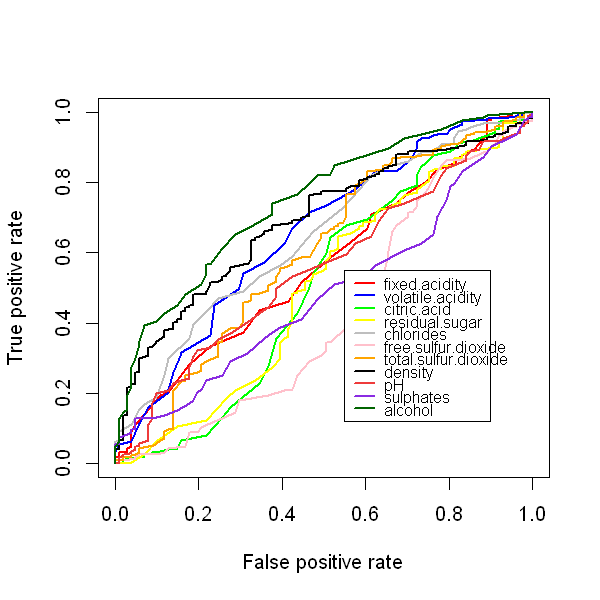

                feature       AUC
2      volatile.acidity 0.7951620
6   free.sulfur.dioxide 0.7648760
4        residual.sugar 0.7597942
10            sulphates 0.7584627
9                    pH 0.7581803
1         fixed.acidity 0.7563805
8               density 0.7562924
5             chlorides 0.7561691
3           citric.acid 0.7555847
7  total.sulfur.dioxide 0.7542057

current model is  "quality ~ 1  + alcohol + volatile.acidity"
current AUC is  0.795162

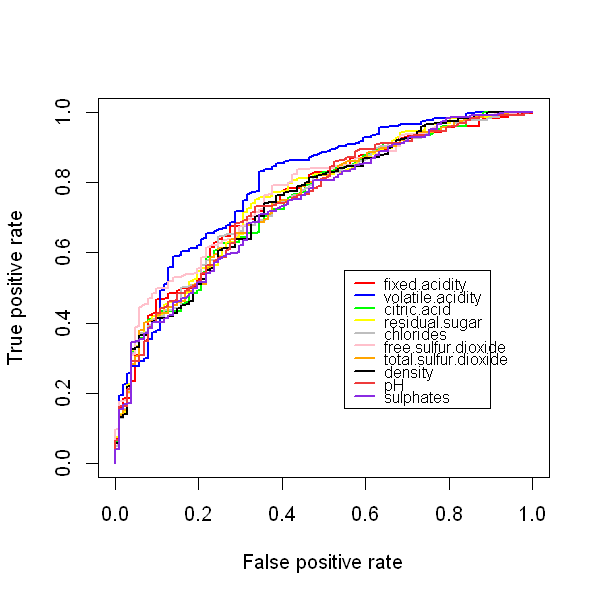

               feature       AUC
3       residual.sugar 0.8022316
5  free.sulfur.dioxide 0.8004775
1        fixed.acidity 0.7984159
7              density 0.7982982
9            sulphates 0.7974449
8                   pH 0.7965892
6 total.sulfur.dioxide 0.7961374
4            chlorides 0.7951736
2          citric.acid 0.7950188

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar"
current AUC is  0.8022316

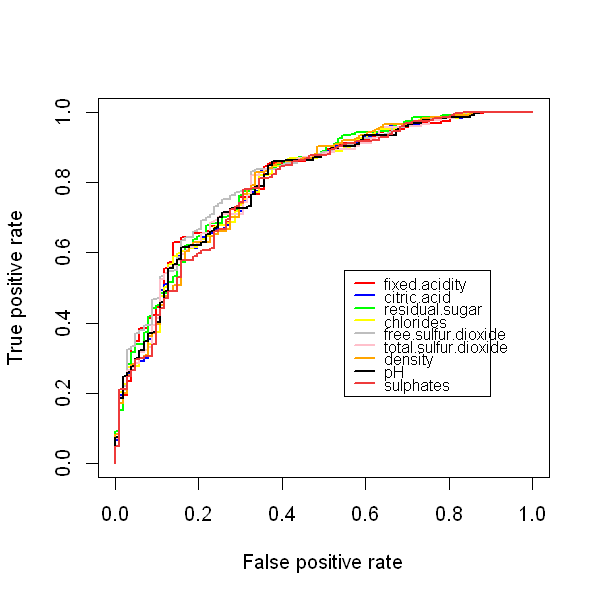

               feature       AUC
1        fixed.acidity 0.8059836
4  free.sulfur.dioxide 0.8048142
8            sulphates 0.8044848
7                   pH 0.8043831
6              density 0.8029197
2          citric.acid 0.8021101
5 total.sulfur.dioxide 0.8019718
3            chlorides 0.8018930

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity"
current AUC is  0.8059836

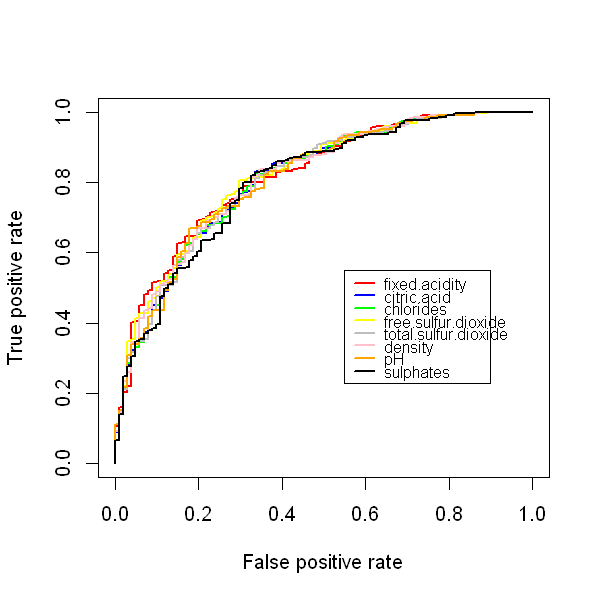

               feature       AUC
7            sulphates 0.8080022
3  free.sulfur.dioxide 0.8072857
6                   pH 0.8063113
5              density 0.8058126
1          citric.acid 0.8057403
2            chlorides 0.8057284
4 total.sulfur.dioxide 0.8057186

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates"
current AUC is  0.8080022

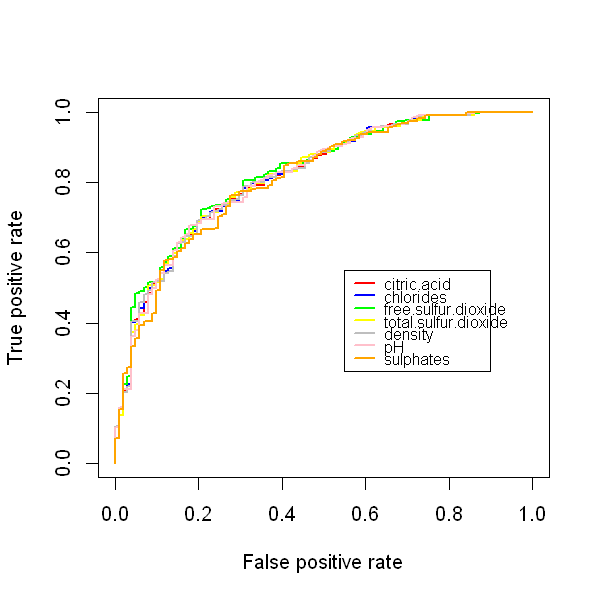

               feature       AUC
3  free.sulfur.dioxide 0.8095632
6                   pH 0.8082994
1          citric.acid 0.8080379
4 total.sulfur.dioxide 0.8079458
2            chlorides 0.8078334
5              density 0.8077892

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide"
current AUC is  0.8095632

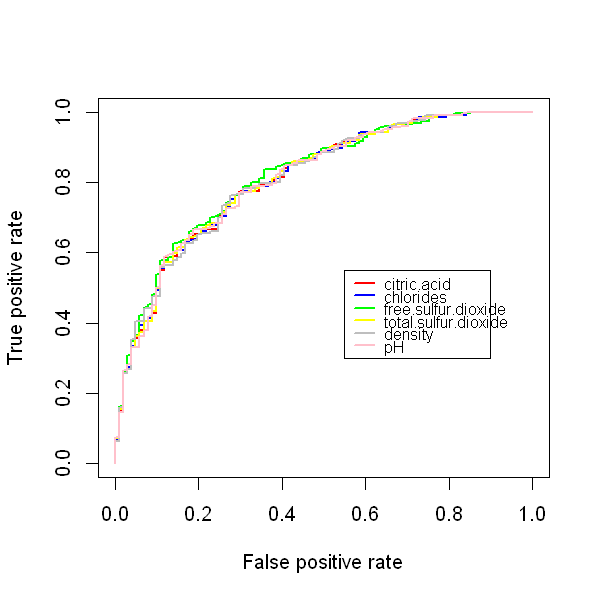

               feature       AUC
3 total.sulfur.dioxide 0.8098996
5                   pH 0.8098423
1          citric.acid 0.8095788
2            chlorides 0.8095144
4              density 0.8092627

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide"
current AUC is  0.8098996

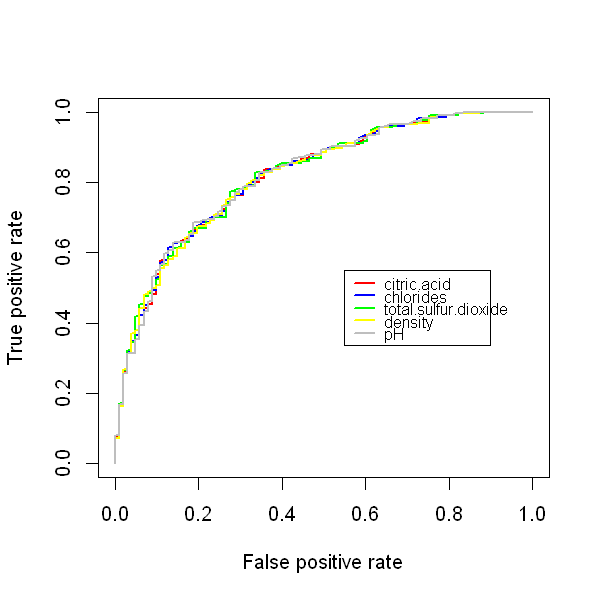

      feature       AUC
4          pH 0.8098577
1 citric.acid 0.8098396
2   chlorides 0.8096620
3     density 0.8095978

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH"
current AUC is  0.8098577

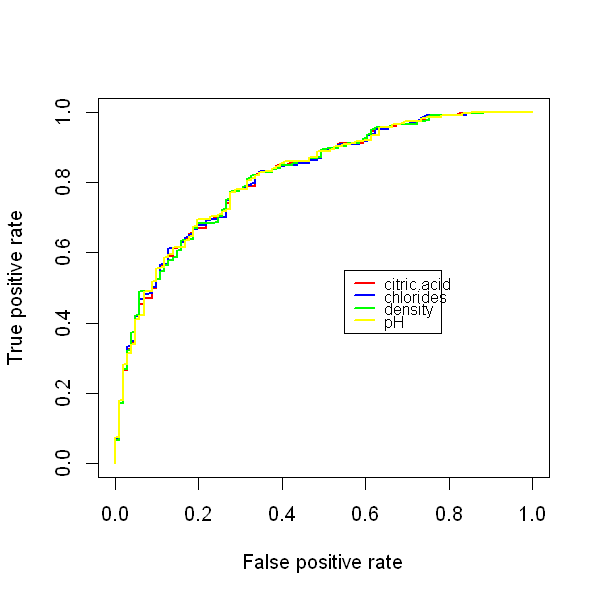

      feature       AUC
3     density 0.8106478
1 citric.acid 0.8098812
2   chlorides 0.8097042

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH + density"
current AUC is  0.8106478

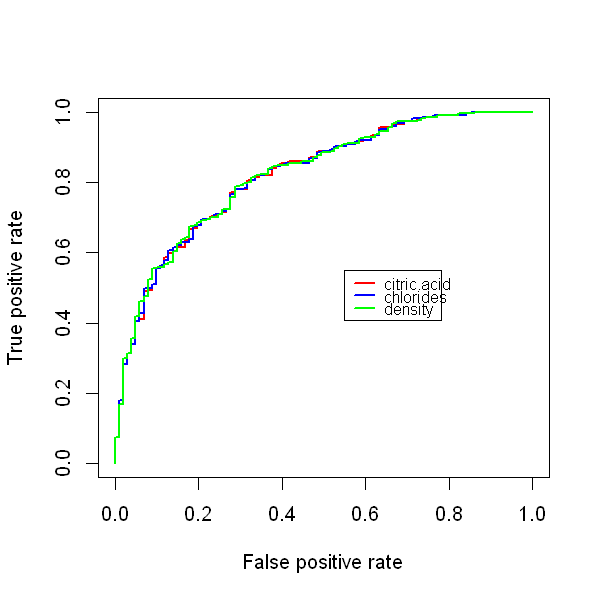

      feature       AUC
1 citric.acid 0.8105108
2   chlorides 0.8104212

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH + density + citric.acid"
current AUC is  0.8105108

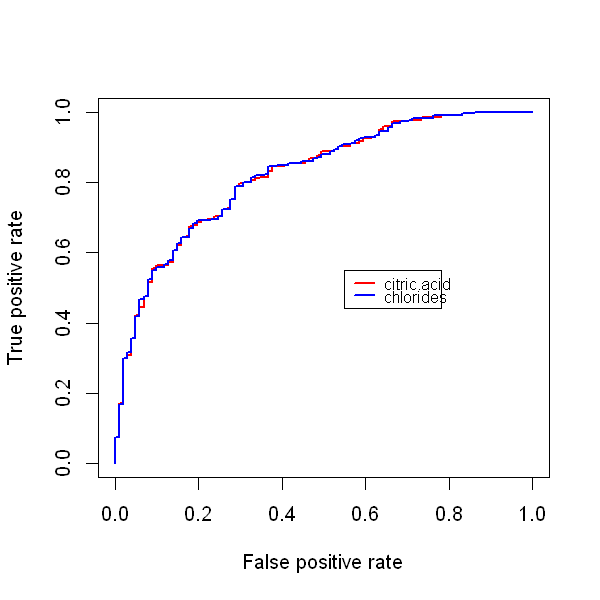

    feature       AUC
1 chlorides 0.8102334

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH + density + citric.acid + chlorides"
current AUC is  0.8102334

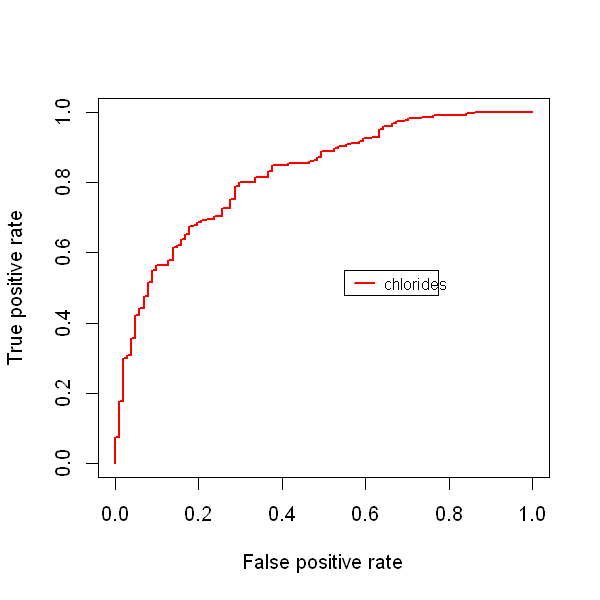

In [25]:
# set plot size for ROC curves
options(repr.plot.width=5, repr.plot.height=5)
# build model using auc as scoring measure
auc <- aucMeasure(train, 'quality', 10)

### Model using AIC
The following model calls the aicMeasure function with the train data, sets 'quality' as the target variable and uses k = 10 for the cross validation (10 folds will be created with a train and test set for each fold). It will print out a bar chart showing the AIC score for each model with each remaining feature added before adding the one that decreases AIC the most.


current model is  "quality ~ 1 "
current AIC is  3776.458 
                feature      AIC
11              alcohol 3210.015
8               density 3511.603
2      volatile.acidity 3618.192
5             chlorides 3657.315
7  total.sulfur.dioxide 3681.677
4        residual.sugar 3741.681
9                    pH 3743.652
1         fixed.acidity 3747.491
10            sulphates 3766.585
6   free.sulfur.dioxide 3778.114
3           citric.acid 3778.355

current model is  "quality ~ 1  + alcohol"
current AIC is  3210.015 


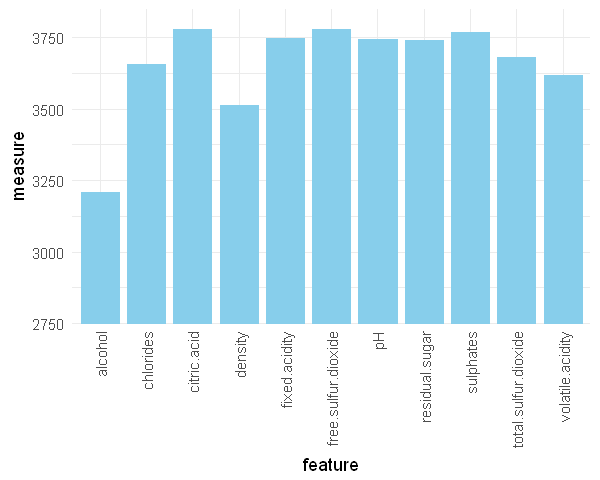

                feature      AIC
2      volatile.acidity 3008.210
6   free.sulfur.dioxide 3172.036
4        residual.sugar 3189.463
10            sulphates 3194.540
1         fixed.acidity 3197.633
9                    pH 3198.793
8               density 3204.345
5             chlorides 3204.912
3           citric.acid 3207.034
7  total.sulfur.dioxide 3211.070

current model is  "quality ~ 1  + alcohol + volatile.acidity"
current AIC is  3008.21 


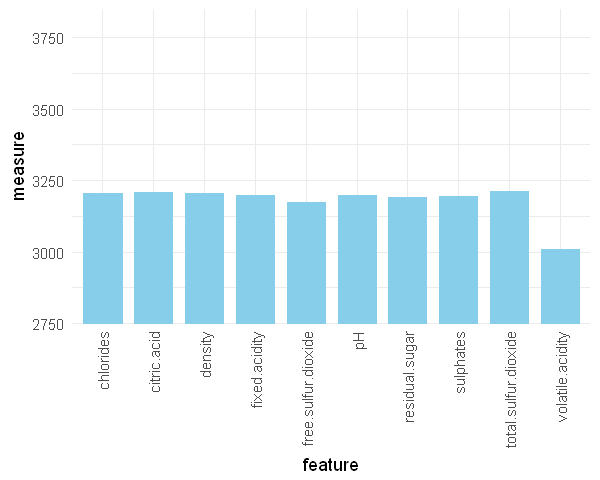

               feature      AIC
3       residual.sugar 2970.887
5  free.sulfur.dioxide 2982.851
7              density 2990.519
1        fixed.acidity 2990.583
9            sulphates 2993.565
6 total.sulfur.dioxide 3000.785
8                   pH 3001.232
4            chlorides 3008.649
2          citric.acid 3010.075

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar"
current AIC is  2970.887 


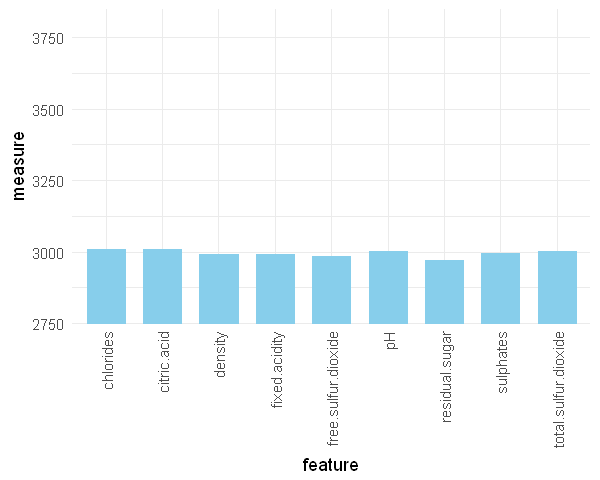

               feature      AIC
1        fixed.acidity 2950.372
8            sulphates 2956.082
7                   pH 2957.504
4  free.sulfur.dioxide 2958.571
6              density 2968.141
5 total.sulfur.dioxide 2970.302
2          citric.acid 2972.521
3            chlorides 2972.671

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity"
current AIC is  2950.372 


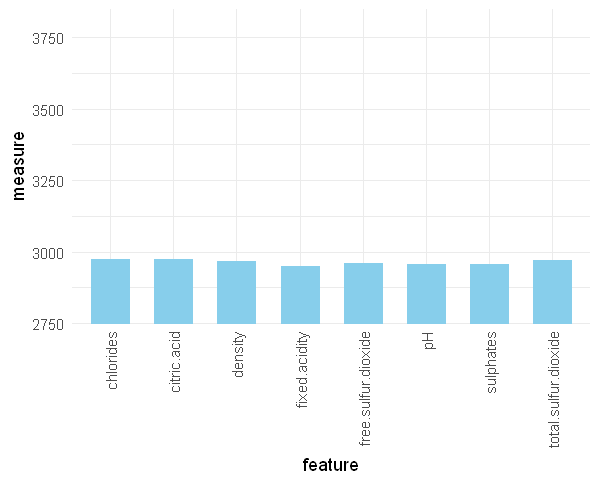

               feature      AIC
7            sulphates 2935.445
3  free.sulfur.dioxide 2941.737
6                   pH 2947.512
4 total.sulfur.dioxide 2949.669
1          citric.acid 2951.501
2            chlorides 2952.034
5              density 2952.216

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates"
current AIC is  2935.445 


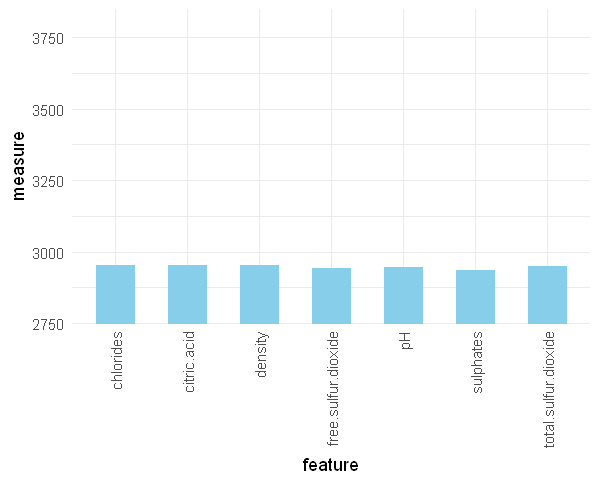

               feature      AIC
3  free.sulfur.dioxide 2927.592
6                   pH 2935.081
5              density 2935.972
4 total.sulfur.dioxide 2936.548
1          citric.acid 2936.989
2            chlorides 2937.135

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide"
current AIC is  2927.592 


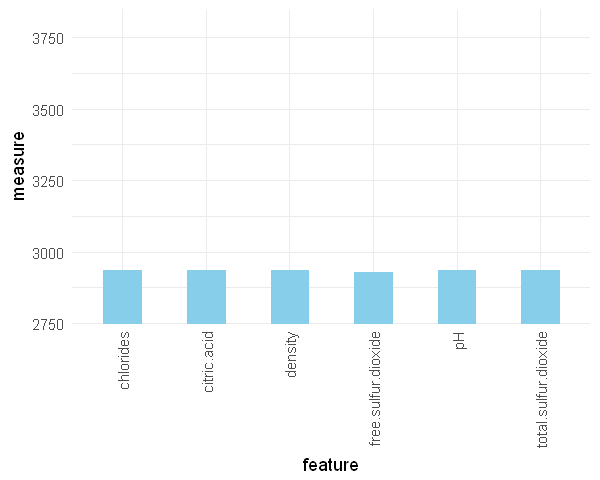

               feature      AIC
5                   pH 2927.203
3 total.sulfur.dioxide 2927.945
4              density 2928.333
2            chlorides 2929.086
1          citric.acid 2929.315

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH"
current AIC is  2927.203 


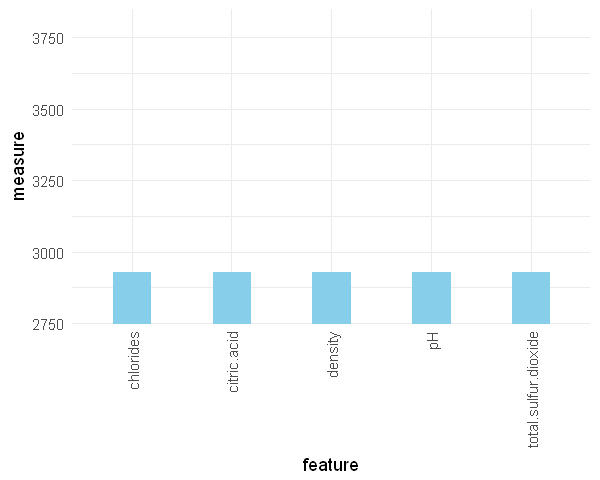

               feature      AIC
4              density 2922.933
3 total.sulfur.dioxide 2927.010
1          citric.acid 2928.759
2            chlorides 2928.845

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density"
current AIC is  2922.933 


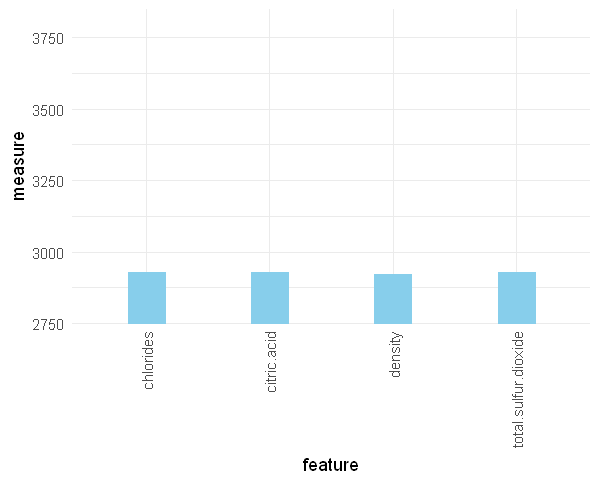

               feature      AIC
3 total.sulfur.dioxide 2923.713
1          citric.acid 2924.130
2            chlorides 2924.859

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide"
current AIC is  2923.713 


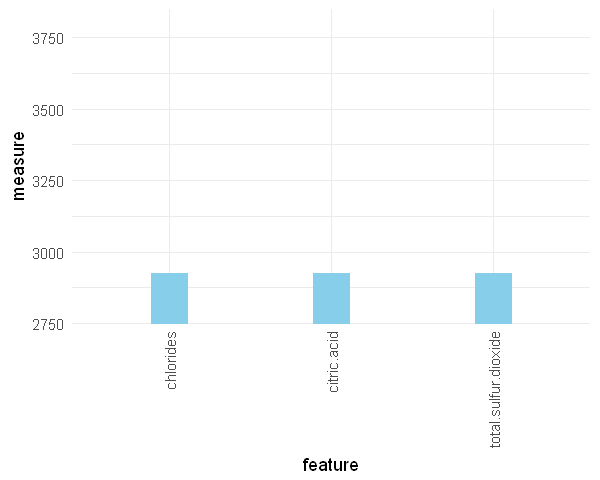

      feature      AIC
1 citric.acid 2924.854
2   chlorides 2925.631

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide + citric.acid"
current AIC is  2924.854 


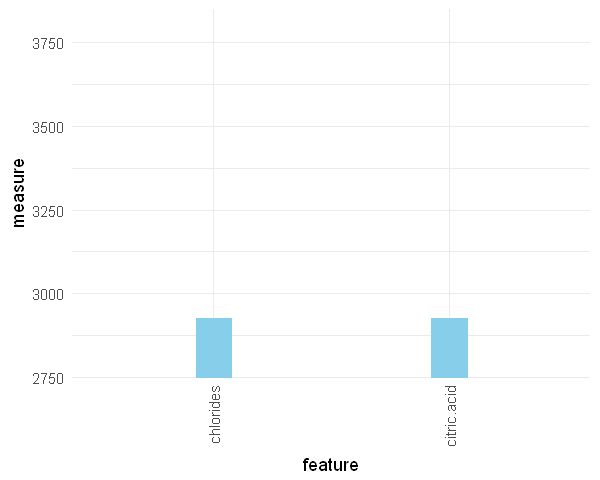

    feature      AIC
1 chlorides 2926.739

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide + citric.acid + chlorides"
current AIC is  2926.739 


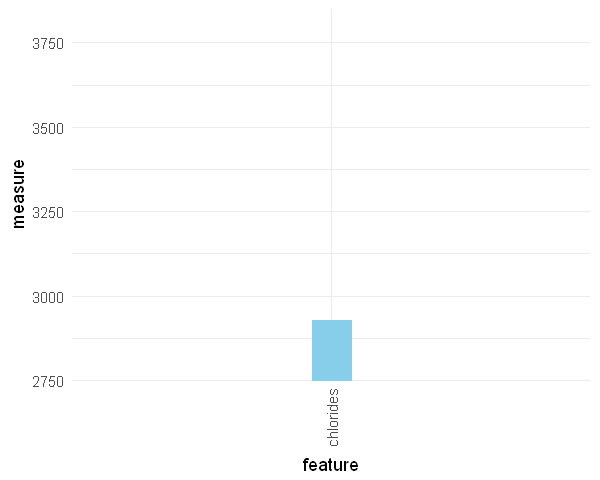

In [26]:
# set plot size for bar chats
options(repr.plot.width=5, repr.plot.height=4)
# build models using AIC as scoring measure
aic <- aicMeasure(train, 'quality', 10)

### Model using BIC
The following model calls the bicMeasure function with the train data, sets 'quality' as the target variable and uses k = 10 for the cross validation (10 folds will be created with a train and test set for each fold). It will print out a bar chart showing the BIC score for each model with each remaining feature added before adding the one that decreases BIC the most.


current model is  "quality ~ 1 "
current BIC is  3782.51 
                feature      BIC
11              alcohol 3222.029
8               density 3523.604
2      volatile.acidity 3630.146
5             chlorides 3669.411
7  total.sulfur.dioxide 3693.668
4        residual.sugar 3753.674
9                    pH 3755.596
1         fixed.acidity 3759.563
10            sulphates 3778.559
6   free.sulfur.dioxide 3790.216
3           citric.acid 3790.447

current model is  "quality ~ 1  + alcohol"
current BIC is  3222.029 


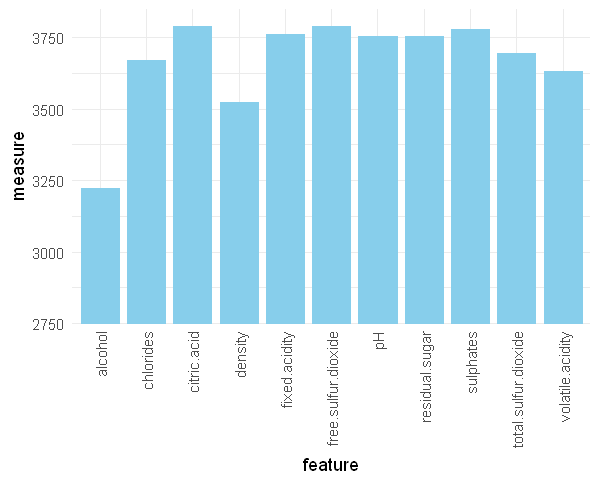

                feature      BIC
2      volatile.acidity 3026.106
6   free.sulfur.dioxide 3190.087
4        residual.sugar 3207.433
10            sulphates 3212.467
1         fixed.acidity 3215.713
9                    pH 3216.742
8               density 3222.384
5             chlorides 3222.900
3           citric.acid 3225.102
7  total.sulfur.dioxide 3229.024

current model is  "quality ~ 1  + alcohol + volatile.acidity"
current BIC is  3026.106 


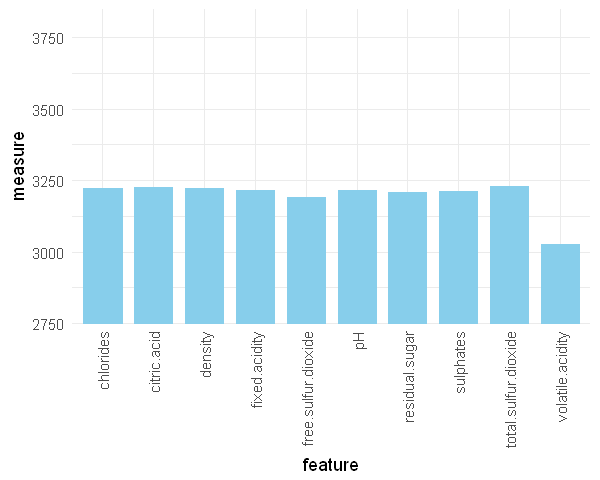

               feature      BIC
3       residual.sugar 2994.764
5  free.sulfur.dioxide 3006.740
7              density 3014.442
1        fixed.acidity 3014.517
9            sulphates 3017.369
6 total.sulfur.dioxide 3024.581
8                   pH 3025.068
4            chlorides 3032.486
2          citric.acid 3034.023

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar"
current BIC is  2994.764 


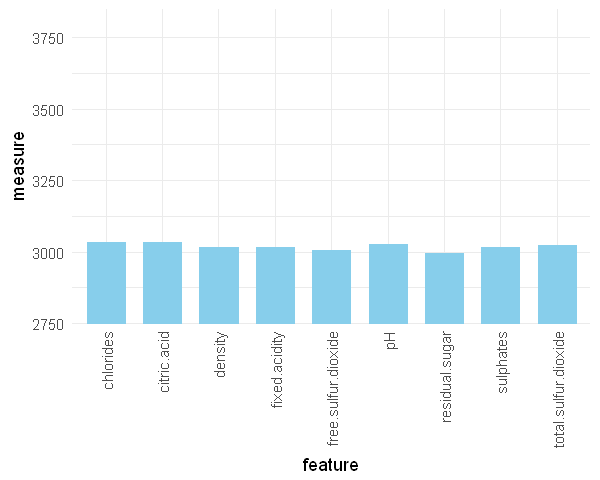

               feature      BIC
1        fixed.acidity 2980.299
8            sulphates 2985.883
7                   pH 2987.329
4  free.sulfur.dioxide 2988.480
6              density 2998.054
5 total.sulfur.dioxide 3000.130
2          citric.acid 3002.430
3            chlorides 3002.505

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity"
current BIC is  2980.299 


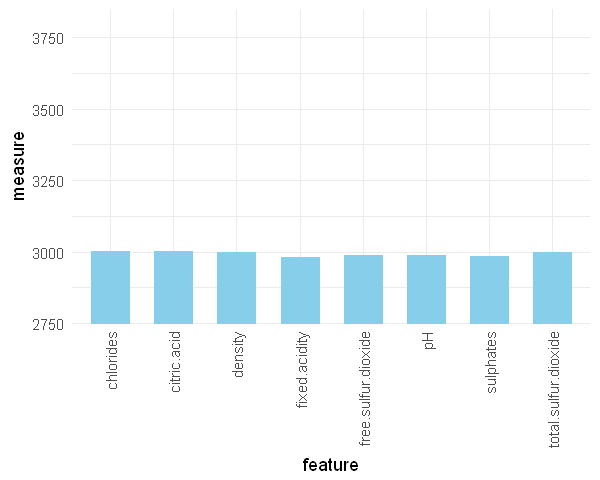

               feature      BIC
7            sulphates 2971.300
3  free.sulfur.dioxide 2977.685
6                   pH 2983.365
4 total.sulfur.dioxide 2985.555
1          citric.acid 2987.451
2            chlorides 2987.905
5              density 2988.185

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates"
current BIC is  2971.3 


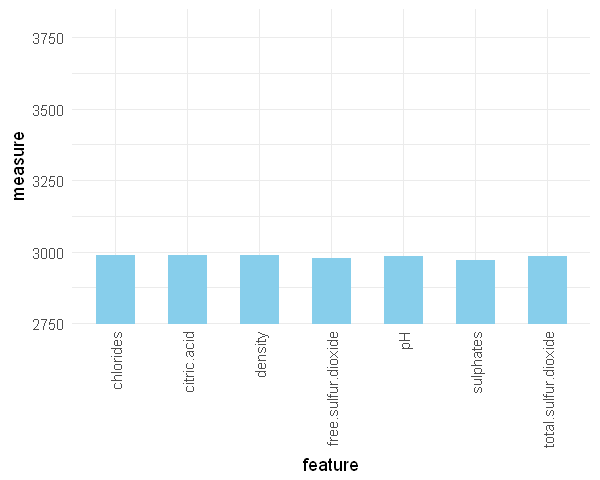

               feature      BIC
3  free.sulfur.dioxide 2969.474
6                   pH 2976.835
5              density 2977.845
4 total.sulfur.dioxide 2978.340
1          citric.acid 2978.862
2            chlorides 2978.928

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide"
current BIC is  2969.474 


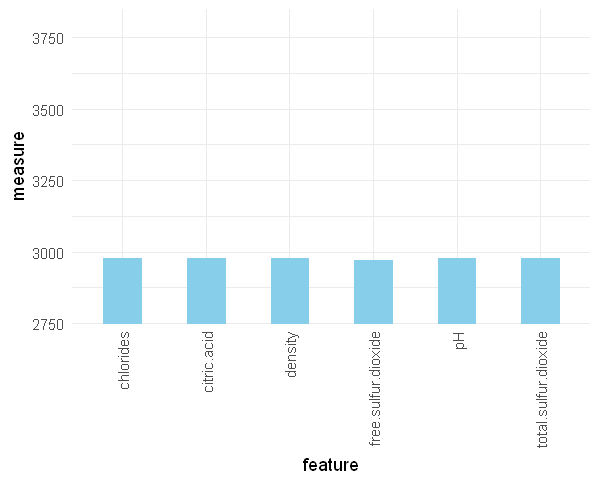

               feature      BIC
5                   pH 2974.977
3 total.sulfur.dioxide 2975.841
4              density 2976.243
2            chlorides 2976.912
1          citric.acid 2977.225

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH"
current BIC is  2974.977 


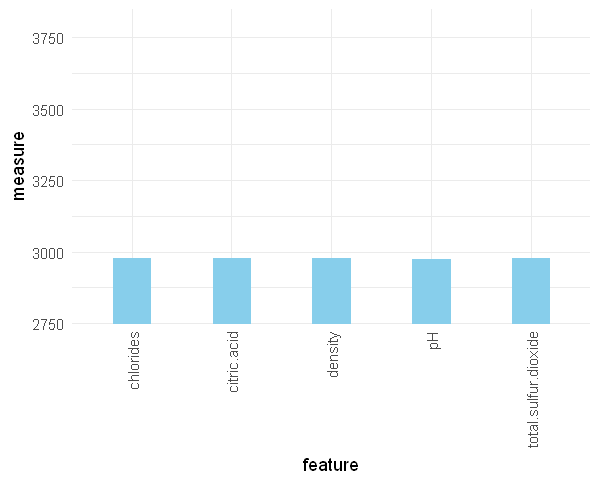

               feature      BIC
4              density 2976.842
3 total.sulfur.dioxide 2980.787
2            chlorides 2982.563
1          citric.acid 2982.576

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density"
current BIC is  2976.842 


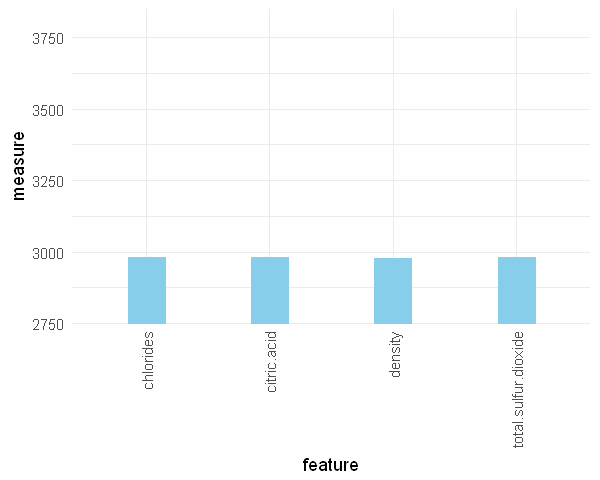

               feature      BIC
3 total.sulfur.dioxide 2983.609
1          citric.acid 2984.080
2            chlorides 2984.742

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide"
current BIC is  2983.609 


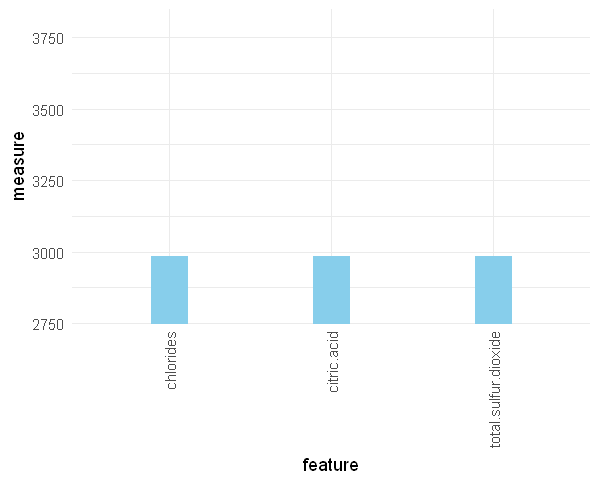

      feature      BIC
1 citric.acid 2990.793
2   chlorides 2991.503

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide + citric.acid"
current BIC is  2990.793 


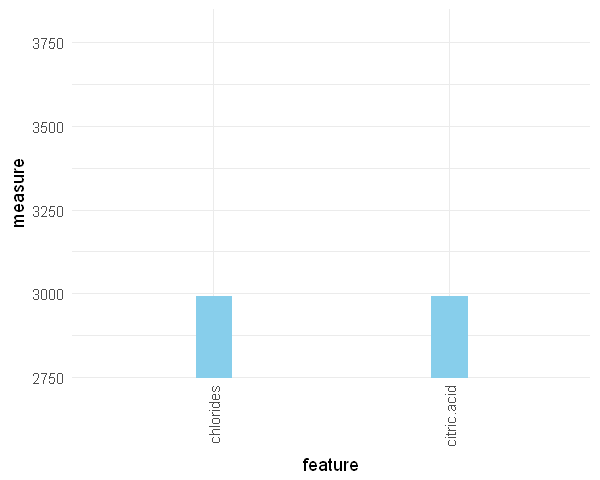

    feature      BIC
1 chlorides 2998.646

current model is  "quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide + citric.acid + chlorides"
current BIC is  2998.646 


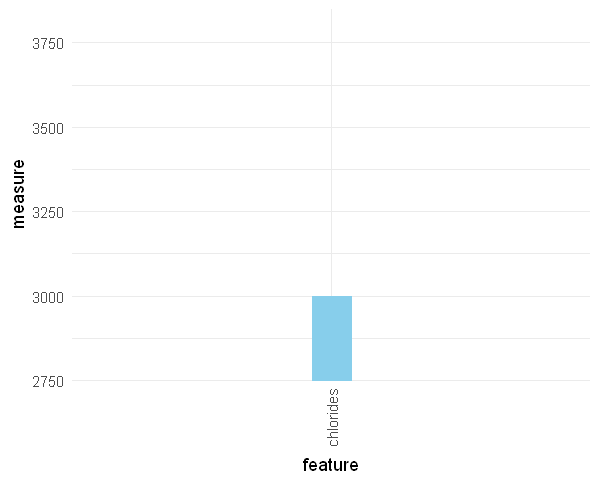

In [27]:
# build model using BIC as scoring measure
bic <- bicMeasure(train, 'quality', 10)

### Model using F-Measure
The following model calls the fmMeasure function with the train data, sets 'quality' as the target variable and uses k = 10 for the cross validation (10 folds will be created with a train and test set for each fold). It will print out a bar chart showing the F-Measure score for each model with each remaining feature added before adding the one that increases the F-Measure the most.


current model is  "quality ~ 1 "
current F-Measure is  0.7973103 
                feature  fMeasure
5             chlorides 0.7989061
1         fixed.acidity 0.7978800
3           citric.acid 0.7973103
6   free.sulfur.dioxide 0.7973103
10            sulphates 0.7973103
9                    pH 0.7970884
4        residual.sugar 0.7955204
11              alcohol 0.7949129
7  total.sulfur.dioxide 0.7929553
2      volatile.acidity 0.7922352
8               density 0.7789848

current model is  "quality ~ 1  + chlorides"
current F-Measure is  0.7989061 


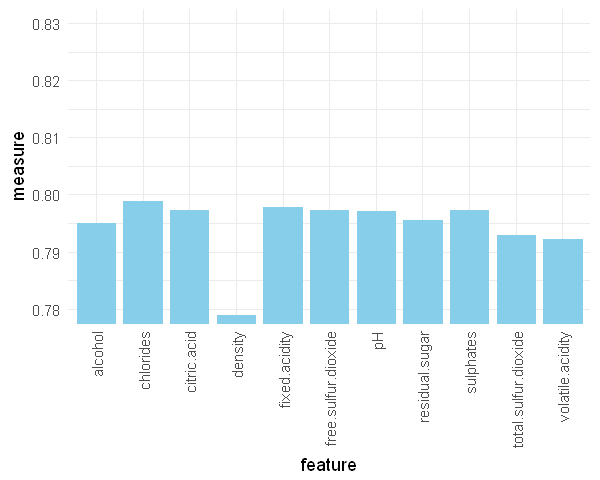

                feature  fMeasure
1         fixed.acidity 0.7996133
5   free.sulfur.dioxide 0.7983789
3           citric.acid 0.7982982
2      volatile.acidity 0.7978292
9             sulphates 0.7977776
6  total.sulfur.dioxide 0.7976977
4        residual.sugar 0.7975803
8                    pH 0.7974261
10              alcohol 0.7969280
7               density 0.7835553

current model is  "quality ~ 1  + chlorides + fixed.acidity"
current F-Measure is  0.7996133 


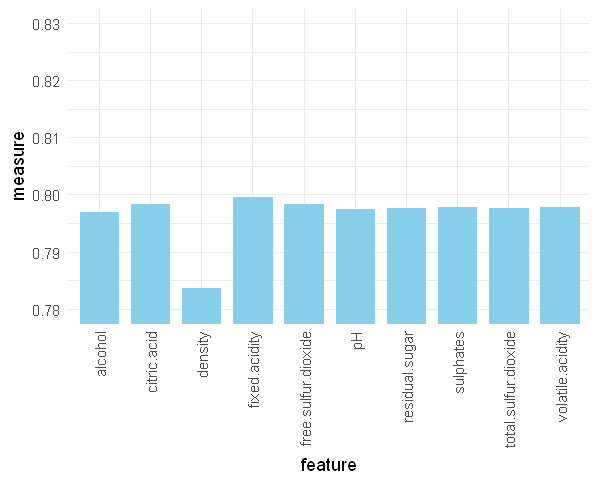

               feature  fMeasure
1     volatile.acidity 0.8014735
4  free.sulfur.dioxide 0.7994734
2          citric.acid 0.7990948
7                   pH 0.7989358
8            sulphates 0.7985971
9              alcohol 0.7967585
3       residual.sugar 0.7958992
5 total.sulfur.dioxide 0.7928950
6              density 0.7838132

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity"
current F-Measure is  0.8014735 


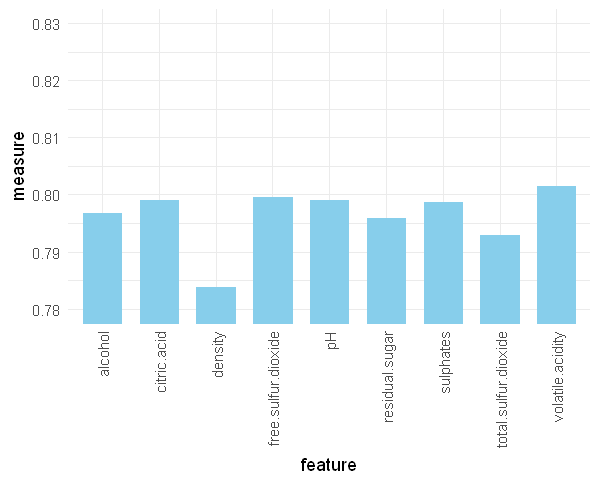

               feature  fMeasure
8              alcohol 0.8180259
6                   pH 0.8028710
2       residual.sugar 0.8017687
4 total.sulfur.dioxide 0.8012569
3  free.sulfur.dioxide 0.8007852
1          citric.acid 0.8006710
7            sulphates 0.7984719
5              density 0.7960775

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol"
current F-Measure is  0.8180259 


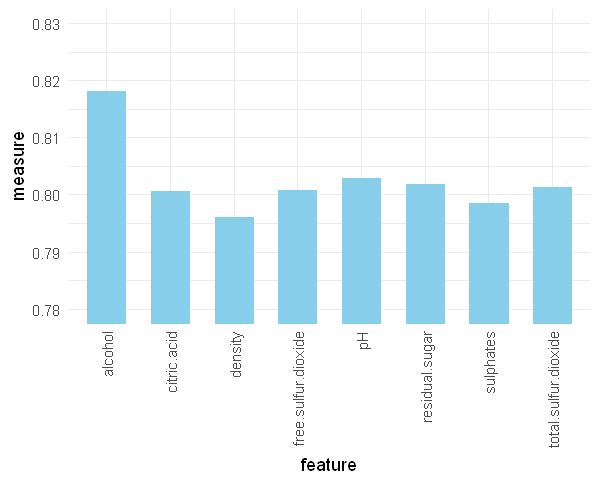

               feature  fMeasure
2       residual.sugar 0.8302806
5              density 0.8273302
3  free.sulfur.dioxide 0.8207227
7            sulphates 0.8186352
6                   pH 0.8180942
1          citric.acid 0.8178347
4 total.sulfur.dioxide 0.8155798

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar"
current F-Measure is  0.8302806 


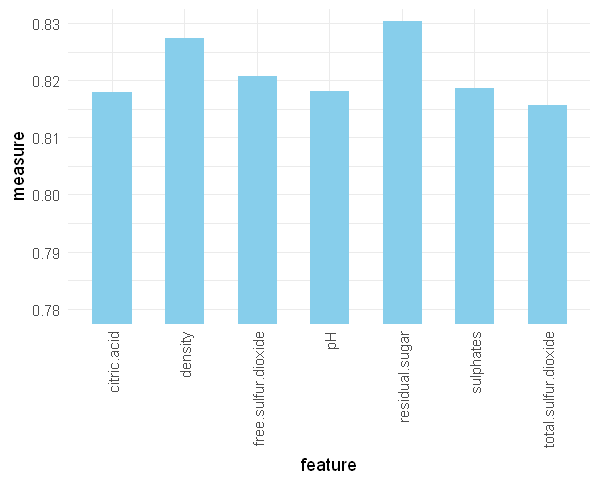

               feature  fMeasure
1          citric.acid 0.8304090
3 total.sulfur.dioxide 0.8303618
4              density 0.8300979
2  free.sulfur.dioxide 0.8286979
5                   pH 0.8271399
6            sulphates 0.8265235

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid"
current F-Measure is  0.830409 


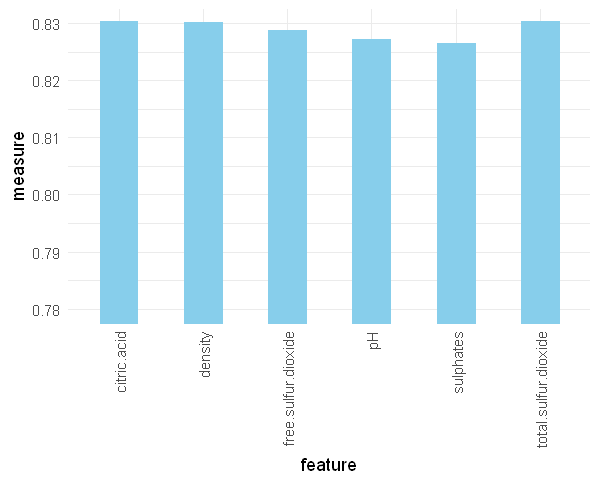

               feature  fMeasure
3              density 0.8299763
4                   pH 0.8292073
2 total.sulfur.dioxide 0.8288440
1  free.sulfur.dioxide 0.8278392
5            sulphates 0.8273726

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density"
current F-Measure is  0.8299763 


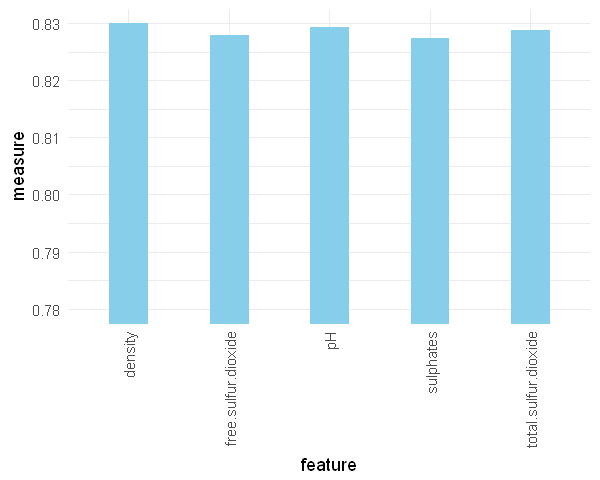

               feature  fMeasure
2 total.sulfur.dioxide 0.8295060
1  free.sulfur.dioxide 0.8279433
3                   pH 0.8275667
4            sulphates 0.8255979

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density + total.sulfur.dioxide"
current F-Measure is  0.829506 


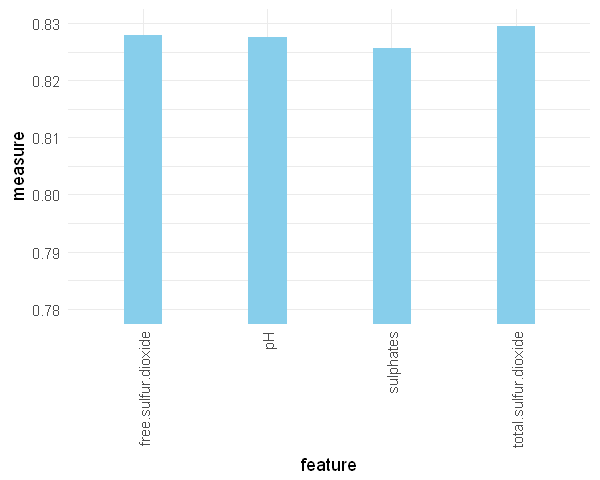

              feature  fMeasure
1 free.sulfur.dioxide 0.8269984
2                  pH 0.8256709
3           sulphates 0.8254395

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density + total.sulfur.dioxide + free.sulfur.dioxide"
current F-Measure is  0.8269984 


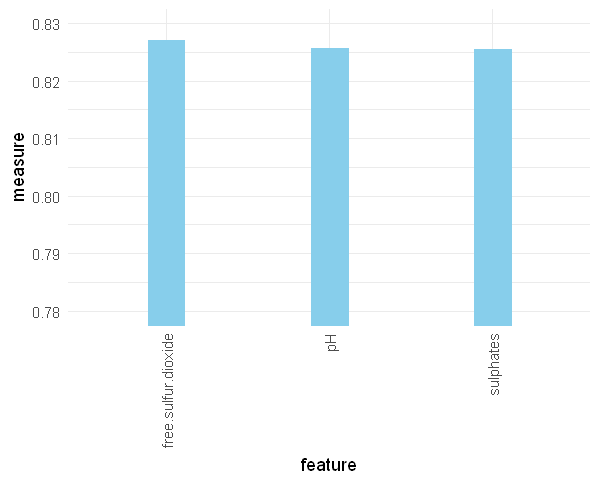

    feature  fMeasure
1        pH 0.8266522
2 sulphates 0.8258045

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density + total.sulfur.dioxide + free.sulfur.dioxide + pH"
current F-Measure is  0.8266522 


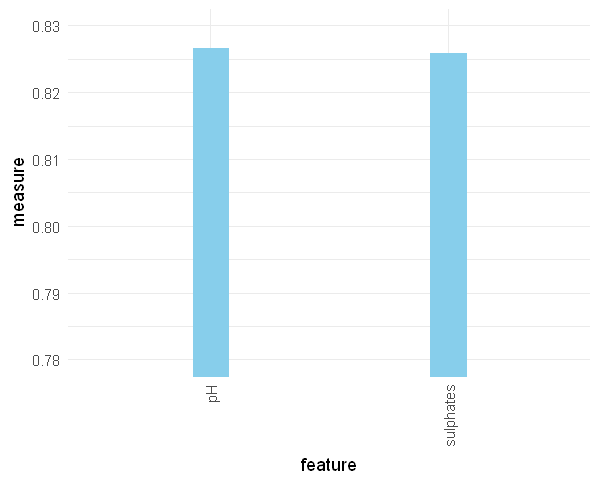

    feature  fMeasure
1 sulphates 0.8280169

current model is  "quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density + total.sulfur.dioxide + free.sulfur.dioxide + pH + sulphates"
current F-Measure is  0.8280169 


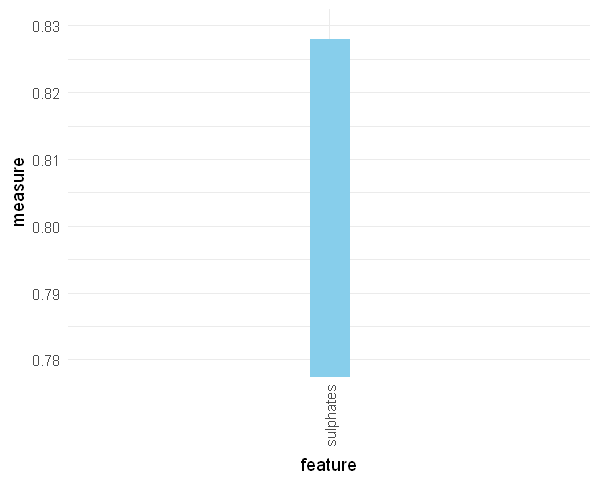

In [28]:
fm <- fmMeasure(train, 'quality', 10)

In [29]:
auc
bestModel <- list()
bestModel$auc <- auc[which.max(auc$AUC),]$model
bestModel$auc
head(train)

feature_count,model,AUC
0,"""quality ~ 1 """,0.5000000
1,"""quality ~ 1 + alcohol""",0.7546103
2,"""quality ~ 1 + alcohol + volatile.acidity""",0.7951620
3,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar""",0.8022316
4,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity""",0.8059836
5,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates""",0.8080022
6,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide""",0.8095632
7,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide""",0.8098996
8,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH""",0.8098577
9,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH + density""",0.8106478


[1] "\"quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH + density\""

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.0,0.27,0.36,20.70,0.045,45,170,1.0010,3.00,0.45,8.8,1
6.3,0.30,0.34,1.60,0.049,14,132,0.9940,3.30,0.49,9.5,1
7.2,0.23,0.32,8.50,0.058,47,186,0.9956,3.19,0.40,9.9,1
8.1,0.28,0.40,6.90,0.050,30,97,0.9951,3.26,0.44,10.1,1
6.2,0.32,0.16,7.00,0.045,30,136,0.9949,3.18,0.47,9.6,1
8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,0


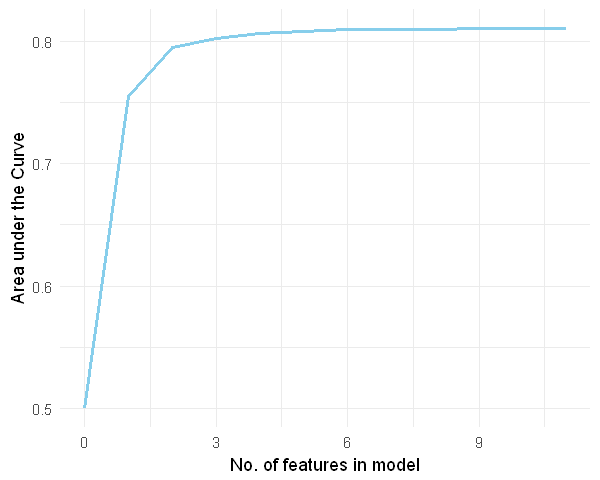

In [30]:
ggplot(aes(x = feature_count, y = AUC), data = auc) + geom_line(size = 1, color = 'skyblue') + theme_minimal() + labs(x = "No. of features in model", y = "Area under the Curve")

We can see that when using area under the curve as the selection method the features are added in the following order:<br>
1) alcohol <br>
2) volatile.acidity <br>
3) residual.sugar <br>
4) fixed.acidity <br>
5) sulphates <br>
6) free.sulfur.dioxide <br>
7) total.sulfur.dioxide <br>
8) citric.acid <br>
9) pH <br>
10) desnity<br>
11) chlorides<br><br>
As the features are added the AUC continues to climb until eight features are included in the model. The measure then drops off before climbing again and all features are added to the model. <br>
<b>quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + citric.acid + pH + density + chlorides</b>


In [31]:
aic
bestModel$aic <- aic[which.min(aic$AIC),]$model
bestModel$aic

feature_count,model,AIC
0,"""quality ~ 1 """,3776.458
1,"""quality ~ 1 + alcohol""",3210.015
2,"""quality ~ 1 + alcohol + volatile.acidity""",3008.210
3,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar""",2970.887
4,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity""",2950.372
5,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates""",2935.445
6,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide""",2927.592
7,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH""",2927.203
8,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density""",2922.933
9,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide""",2923.713


[1] "\"quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density\""

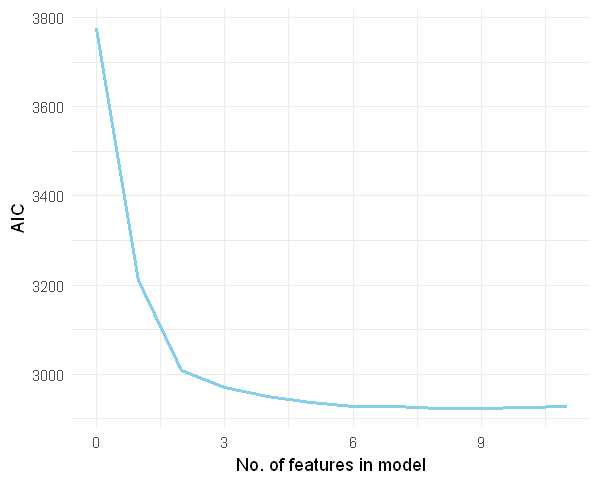

In [32]:
ggplot(aes(x = feature_count, y = AIC), data = aic) + geom_line(size = 1, color = 'skyblue') + theme_minimal() + labs(x = "No. of features in model", y = "AIC")

In comparison to AUC using AIC as the feature selection measure results in a different order of features. Using AIC as the feature selection method the features are added in the following order:<br>
1) alcohol <br>
2) volatile.acidity <br>
3) residual.sugar <br>
4) fixed.acidity <br>
5) sulphates <br>
6) free.sulfur.dioxide <br>
7) pH <br>
8) density <br>
9) total.sulfur.dioxide <br>
10) citric.acid<br><br>
The minimum AIC measure is also found when eight features are selected and thus the best model according to AIC forward selection is the same as AUC<br>
<b>quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density</b>

In [33]:
bic
bestModel$bic <- bic[which.min(bic$BIC),]$model
bestModel$bic

feature_count,model,BIC
0,"""quality ~ 1 """,3782.510
1,"""quality ~ 1 + alcohol""",3222.029
2,"""quality ~ 1 + alcohol + volatile.acidity""",3026.106
3,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar""",2994.764
4,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity""",2980.299
5,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates""",2971.300
6,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide""",2969.474
7,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH""",2974.977
8,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density""",2976.842
9,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide""",2983.609


[1] "\"quality ~ 1  + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide\""

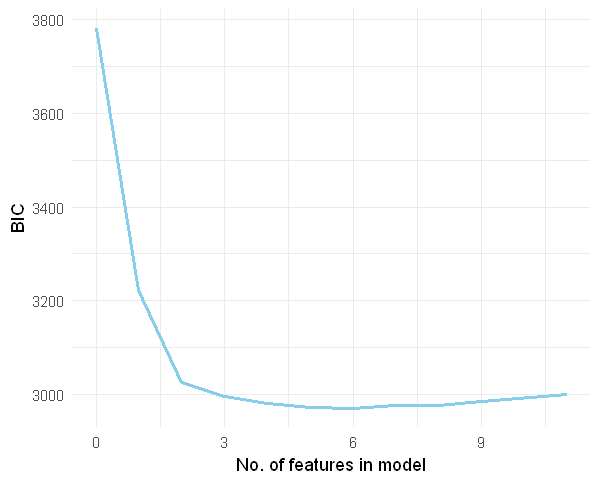

In [34]:
ggplot(aes(x = feature_count, y = BIC), data = bic) + geom_line(size = 1, color = 'skyblue') + theme_minimal() + labs(x = "No. of features in model", y = "BIC")

Using BIC as the feature selection method results in exactly the same order of selected features as using AIC:<br>
1) alcohol <br>
2) volatile.acidity <br>
3) residual.sugar <br>
4) fixed.acidity <br>
5) sulphates <br>
6) free.sulfur.dioxide <br>
7) pH <br>
8) density <br>
9) total.sulfur.dioxide <br>
10) citric.acid<br><br>
However the minimum BIC measure is found earlier than with AIC when six features are selected and thus the best model according to BIC forward selection is<br>
<b>quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide</b>


In [35]:
fm
bestModel$fMeasure <- fm[which.max(fm$fMeasure),]$model
bestModel$fMeasure

feature_count,model,fMeasure
0,"""quality ~ 1 """,0.7973103
1,"""quality ~ 1 + chlorides""",0.7989061
2,"""quality ~ 1 + chlorides + fixed.acidity""",0.7996133
3,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity""",0.8014735
4,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol""",0.8180259
5,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar""",0.8302806
6,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid""",0.8304090
7,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density""",0.8299763
8,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density + total.sulfur.dioxide""",0.8295060
9,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid + density + total.sulfur.dioxide + free.sulfur.dioxide""",0.8269984


[1] "\"quality ~ 1  + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid\""

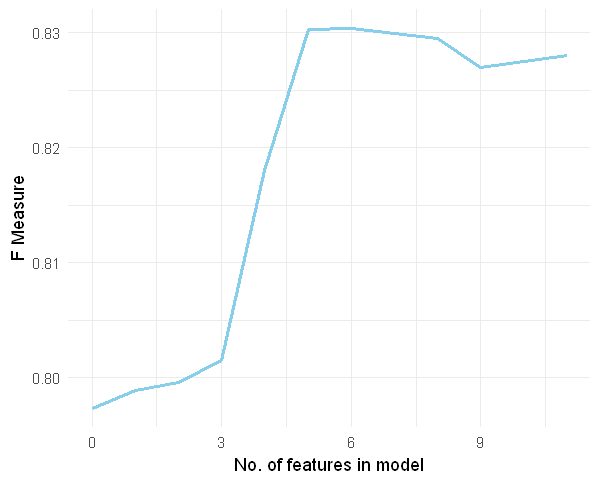

In [36]:
ggplot(aes(x = feature_count, y = fMeasure), data = fm) + geom_line(size = 1, color = 'skyblue') + theme_minimal() + labs(x = "No. of features in model", y = "F Measure")

Using F-Measure results in a very different order to both AUC, AIC/ BIC: <br>
1) chlorides <br>
2) fixed.acidity <br>
3) volatile.acidity <br>
4) alcohol <br>
5) residual.sugar <br>
6) citric.acid <br>
7) density <br>
8) total.sulfur.dioxide <br>
9) pH <br>
10) free.sulfur.dioxide <br>
The maximum F-Measure is found when seven features are selected and thus the best model according to F-Measure forward selection is:<br>
<b>quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + total.sulfur.dioxide + density</b>

## Ridge and LASSO

Ridge and LASSO (Least Absolute Shrinkage and Selection Operator) are regaularisation techniques that both penalize the size of the feature coeffcients. Ridge regression penalizes the sum of the square of the coefficents while LASSO as the name suggests minimises the sum of the absolute values of the coefficients. Although both methods will reduce the size of the coeffcients Ridge will not 'zero out' the coefficients so therefore does not select features. The amount of penalization that both regularises implement can be controlled by setting the lambda value.

The glmnet package can build both Ridge and LASSO models (and a blend of both known as elastic-net). glmnet requires the training data to be in a matrix format. The package can use k-fold cross validation in order select the lambda that minimises a selected measure, in this case we will use area under the curve (auc).

In [37]:
# convert the dataframes into matrices (delete the intercept)
x_training <- model.matrix(quality ~ . , train)[, -1]

### Build LASSO model

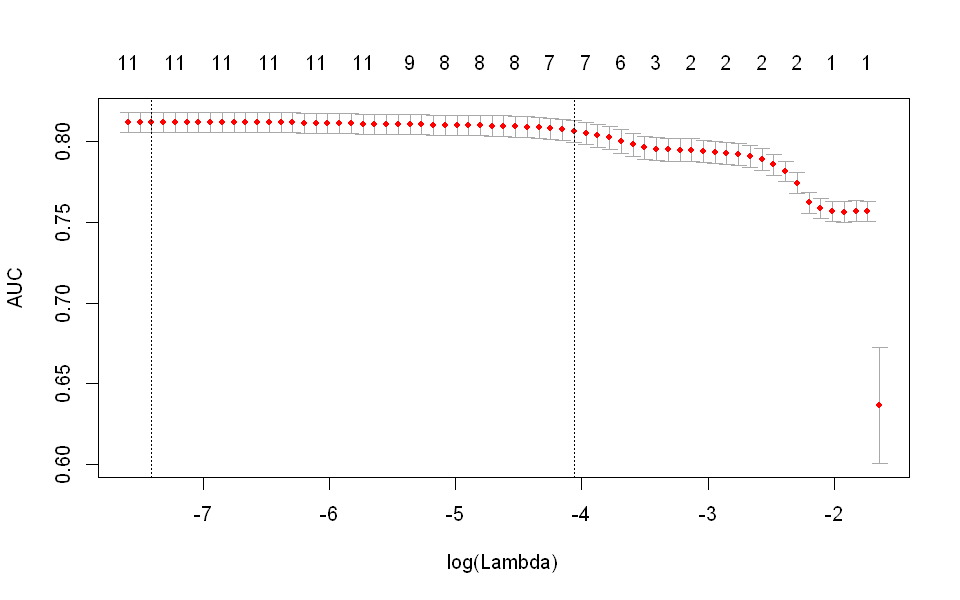

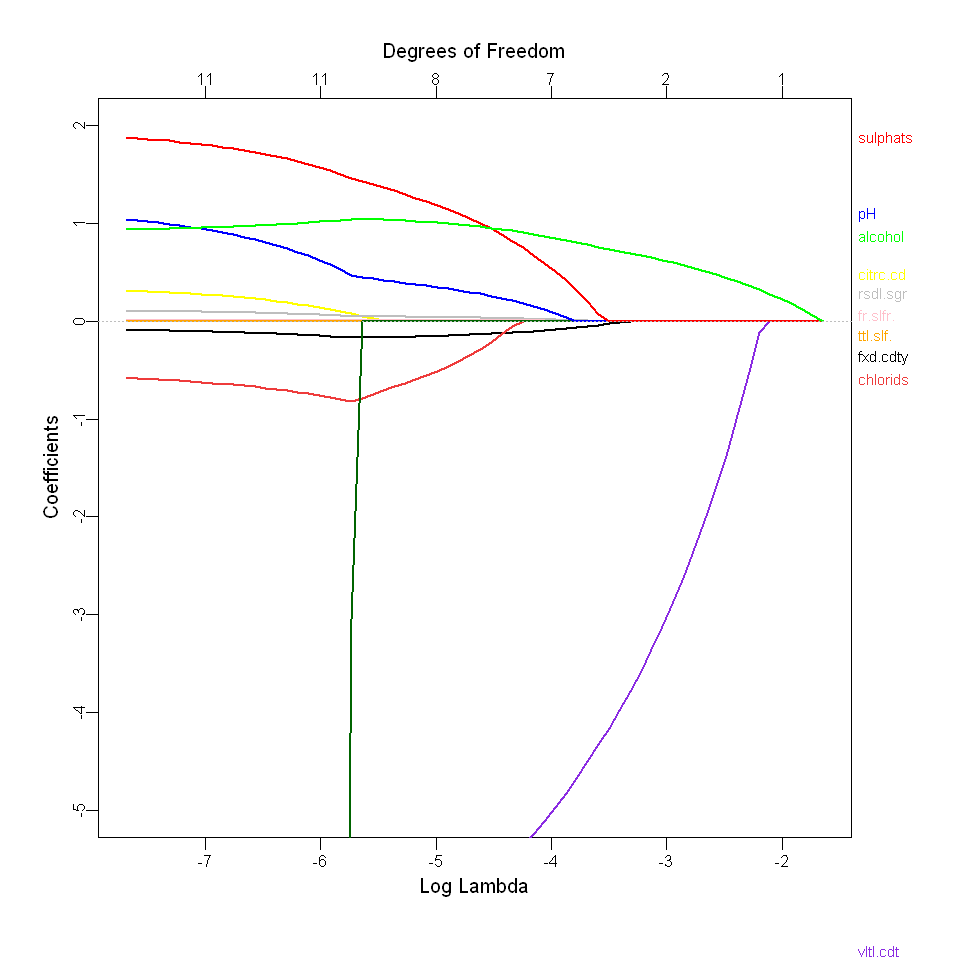

In [38]:
# set height and width for plots
options(repr.plot.width=8, repr.plot.height=5)
# build lasso model (alpha = 1)
bestModel$lasso <- glmnet(x_training, y= train$quality, family = 'binomial', alpha = 1)
# performs cross validation with 10 folds to select the best lamda value for Lasso regression (use auc as measure)
cv.lasso.model <- cv.glmnet(x_training, train$quality, family = 'binomial', type.measure="auc", alpha=1, nfolds = 10)
# plot the AUC value vs the log(lambda)
plot(cv.lasso.model)
# set height and width for plots
options(repr.plot.width=8, repr.plot.height=8)
# plot the coefficients
plot_glmnet(bestModel$lasso, xvar = 'lambda', col = c('red', 'blue', 'green', 'yellow', 'gray', 'pink', 'orange', 'black', 'brown2', 'blueviolet', 'darkgreen', 'darkseagreen'), label = TRUE, ylim=c(-5,2), lwd =2) #plots model, assign color

LASSO penalization performs feature selection by zeroing out the coefficeints. The higher the penalty (lamda) the more featuress will be removed from the model.

### Build Ridge model

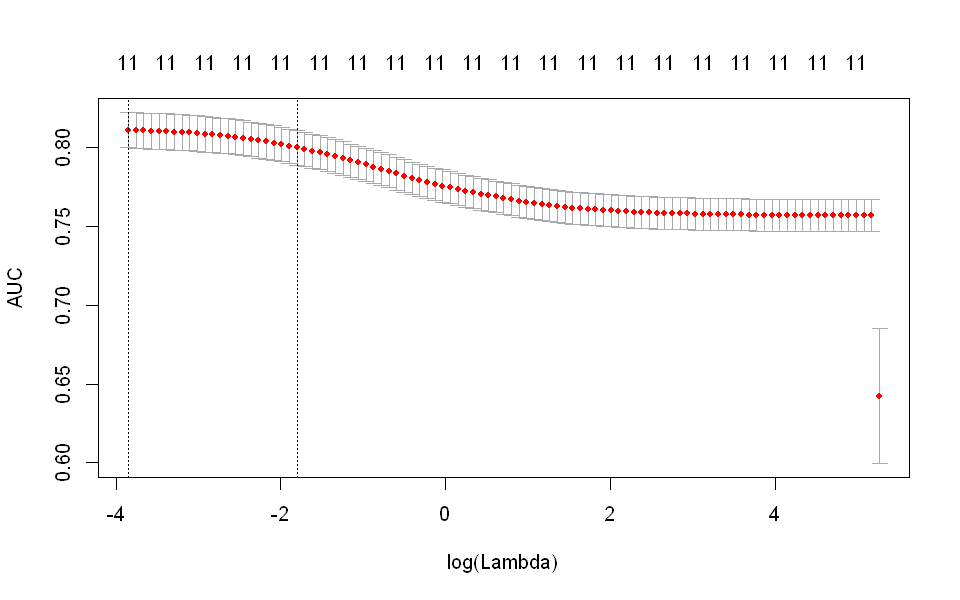

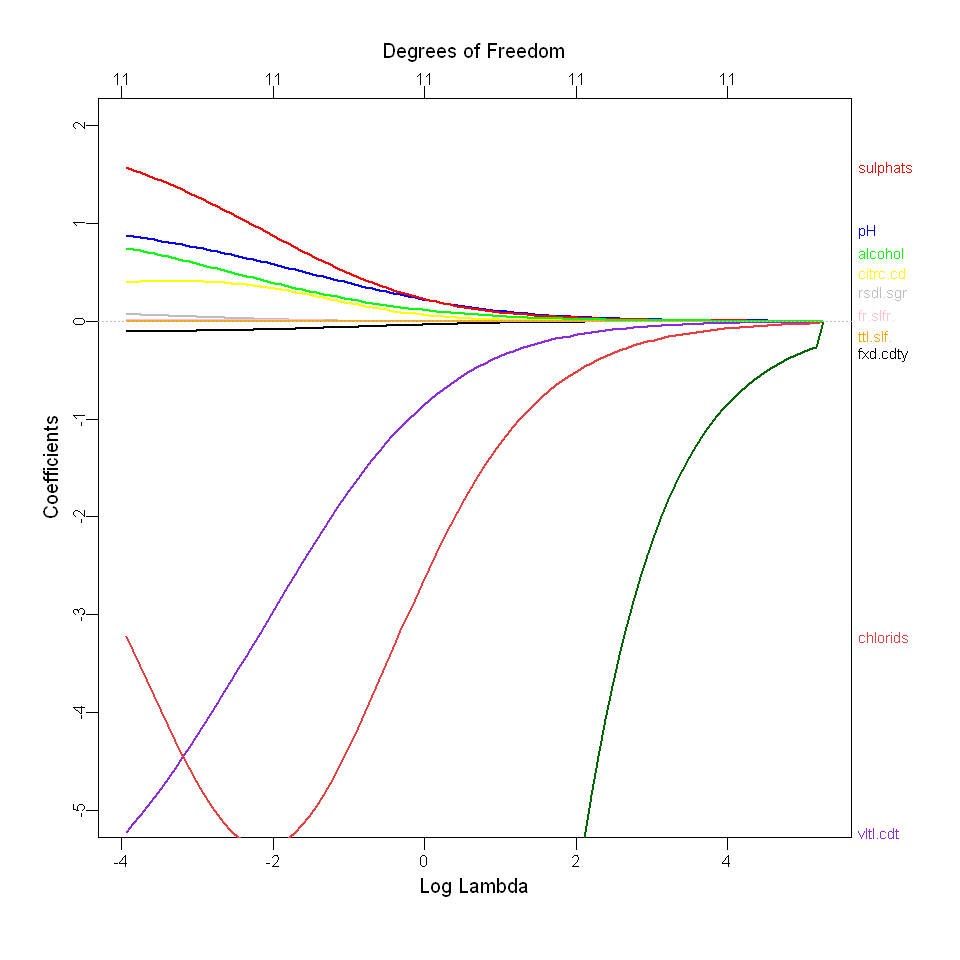

In [39]:
# set height and width for plots
options(repr.plot.width=8, repr.plot.height=5)
# build ridge model (alpha = 0)
bestModel$ridge <- glmnet(x_training, y= train$quality, family = 'binomial', alpha = 0)
# performs cross validation with 10 folds to select the best lamda value for ridge regression (use auc as measure)
cv.ridge.model <- cv.glmnet(x_training, train$quality, family = 'binomial', type.measure="auc", alpha=0, nfolds = 10)
# plot the AUC value vs the log(lambda)
plot(cv.ridge.model)
# set height and width for plots
options(repr.plot.width=8, repr.plot.height=8)
# plot the coefficients
plot_glmnet(bestModel$ridge, xvar = 'lambda', col = c('red', 'blue', 'green', 'yellow', 'gray', 'pink', 'orange', 'black', 'brown2', 'blueviolet', 'darkgreen', 'darkseagreen'), label = TRUE, ylim=c(-5,2), lwd =2) #plots model, assign color


Ridge penalization reduces the size of the coefficients without ever completely elimating them.

## Evaluating Model Performance

There are many different ways to evaluate model performance, in fact we have built two of the models based on the performance measures Area Under the ROC curve and F-Measure. In all we have built six models:
* Area Under Curve (AUC)
* Aikaikes Information Criterion (AIC)
* Bayesian Information Criterion (BIC)
* F-Measure (fMeasure)
* Ridge Regression (ridge)
* LASSO Regression (lasso)
* Predictive Accuracy

To determine which model performs the best we will use both AUC and Predictive Accuracy. We will place more importance on AUC in the case that the leading performer by each measure is a different model.

In [40]:
# load the testing file
test = read.csv("Wine_testing_dataset_2017.csv")
test = as.data.frame(test)
head(test)

sapply(test,function(x) sum(is.na(x)))

sapply(test, function(x) length(unique(x)))

summary(test)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
4.9,0.235,0.27,11.75,0.030,34,118,0.99540,3.07,0.50,9.400000,good
6.0,0.410,0.23,1.10,0.066,22,148,0.99266,3.30,0.47,9.633333,bad
6.4,0.350,0.51,7.80,0.055,53,177,0.99502,3.12,0.45,9.600000,bad
5.2,0.405,0.15,1.45,0.038,10,44,0.99125,3.52,0.40,11.600000,bad
5.8,0.290,0.27,1.60,0.062,17,140,0.99138,3.23,0.35,11.100000,good
7.3,0.350,0.67,8.30,0.053,10,100,0.99590,3.19,0.50,10.900000,bad


fixed.acidity     volatile.acidity          citric.acid 
                   0                    0                    0 
      residual.sugar            chlorides  free.sulfur.dioxide 
                   0                    0                    0 
total.sulfur.dioxide              density                   pH 
                   0                    0                    0 
           sulphates              alcohol              quality 
                   0                    0                    0

fixed.acidity     volatile.acidity          citric.acid 
                  51                   78                   67 
      residual.sugar            chlorides  free.sulfur.dioxide 
                 175                   78                   86 
total.sulfur.dioxide              density                   pH 
                 180                  363                   80 
           sulphates              alcohol              quality 
                  62                   65                    2

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 4.200   Min.   :0.1000   Min.   :0.0000   Min.   : 0.700  
 1st Qu.: 6.200   1st Qu.:0.2100   1st Qu.:0.2600   1st Qu.: 1.500  
 Median : 6.700   Median :0.2700   Median :0.3100   Median : 3.975  
 Mean   : 6.777   Mean   :0.2816   Mean   :0.3277   Mean   : 5.353  
 3rd Qu.: 7.300   3rd Qu.:0.3300   3rd Qu.:0.3900   3rd Qu.: 8.275  
 Max.   :10.300   Max.   :0.8500   Max.   :1.0000   Max.   :19.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01300   Min.   :  3.00      Min.   : 10.0        Min.   :0.9871  
 1st Qu.:0.03500   1st Qu.: 20.25      1st Qu.:102.0        1st Qu.:0.9914  
 Median :0.04200   Median : 33.00      Median :130.0        Median :0.9932  
 Mean   :0.04526   Mean   : 34.10      Mean   :134.9        Mean   :0.9935  
 3rd Qu.:0.04975   3rd Qu.: 45.00      3rd Qu.:163.0        3rd Qu.:0.9952  
 Max.   :0.30100   Max.   :110.00      Max.   :366.5   

In [41]:
test$quality <- ifelse(test$quality == 'good', 1, 0)
# prepare matrix for ridge and lasso
x_testing <- model.matrix(quality ~ . , test)[, -1]

## Evaluation of model built from AUC measure

In [42]:
keys <- names(bestModel)
bestModels_df <- data.frame(matrix(, nrow = length(bestModel), ncol = 4))
names(bestModels_df) <- c('model_measure', 'formula', 'AUC', 'Predictive_Accuracy')

for (j in 1:length(bestModel)) {
    bestModels_df[j, 'model_measure'] <- keys[j]
    if (keys[j] == 'ridge' | keys[j] == 'lasso') {
        bestModels_df[j, 'formula'] <- keys[j]
        if (keys[j] == 'ridge') {
            model.prediction <- predict(bestModel$ridge, s=cv.ridge.model$lambda.min, x_testing, type = 'response')
            
        }
        else {
            model.prediction <- predict(bestModel$lasso, s=cv.lasso.model$lambda.min, x_testing, type = 'response')
            
        }
    }
    else {
        bestModels_df[j, 'model_measure'] <- keys[j]
        bestModels_df[j, 'formula'] <- bestModel[j]
        formula = bestModel[[j]]
        model <- glm(formula, family=binomial(link = 'logit'),data = train)
        model.prediction <- predict.glm(model, newdata = test, type = 'response')
        
    }
    
    
    auc_measure <- performance(prediction(model.prediction,test$quality), "auc")
    
    model.prediction <- ifelse(model.prediction > 0.5,1,0)
    
    cm <- confusionMatrix(model.prediction, test$quality)
    bestModels_df[j, 'Predictive_Accuracy'] <- cm$overall[['Accuracy']]
    bestModels_df[j, 'AUC'] <- as.numeric(auc_measure@y.values)
    
}
 
bestModels_df

model_measure,formula,AUC,Predictive_Accuracy
auc,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + total.sulfur.dioxide + pH + density""",0.7639468,0.7050147
aic,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density""",0.7638617,0.7050147
bic,"""quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide""",0.7574287,0.6991150
fMeasure,"""quality ~ 1 + chlorides + fixed.acidity + volatile.acidity + alcohol + residual.sugar + citric.acid""",0.7517620,0.7035398
lasso,lasso,0.7631143,0.7064897
ridge,ridge,0.7629913,0.7138643


## Model Comparison

The BIC and F-Measure models have performed quite poorly in compaison to the AUC, AIC and regularisation algorithms lasso and ridge. The AUC model has the highest AUC score (perhaps not surprsingly) while the Ridge penalization produces the highest predrictive accuracy. In order to make a choice which model is the best we will take a closer look at the confusion matrix for these two models and use a little bit of domain knowledge and personal preference to decide which is the best. When choosing a wine I would rather classify a wine as bad that is actually good than classify a wine as good that is actually bad. That is, I want the wines I classify as good to be good more than I want the wines I classify as bad to be bad because I would rather limit the number of wines I have to select from (classified as good) than select a bad wine that I had classified as good.

### Confusion Matrix for model built by AUC

In [43]:
formula <- bestModel$auc
model <- glm(formula, family=binomial(link = 'logit'),data = train)
model.prediction <- predict.glm(model, newdata = test, type = 'response')
model.prediction <- ifelse(model.prediction > 0.5,1,0)
confusionMatrix(model.prediction, test$quality)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 109  66
         1 134 369
                                          
               Accuracy : 0.705           
                 95% CI : (0.6691, 0.7391)
    No Information Rate : 0.6416          
    P-Value [Acc > NIR] : 0.0002803       
                                          
                  Kappa : 0.3164          
 Mcnemar's Test P-Value : 2.162e-06       
                                          
            Sensitivity : 0.4486          
            Specificity : 0.8483          
         Pos Pred Value : 0.6229          
         Neg Pred Value : 0.7336          
             Prevalence : 0.3584          
         Detection Rate : 0.1608          
   Detection Prevalence : 0.2581          
      Balanced Accuracy : 0.6484          
                                          
       'Positive' Class : 0               
                                          

### Confusion Matrix for model built by Ridge

In [44]:
model.prediction <- predict(bestModel$ridge, s=cv.ridge.model$lambda.min, x_testing, type = 'response')
model.prediction <- ifelse(model.prediction > 0.5,1,0)
confusionMatrix(model.prediction, test$quality)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  98  49
         1 145 386
                                          
               Accuracy : 0.7139          
                 95% CI : (0.6782, 0.7476)
    No Information Rate : 0.6416          
    P-Value [Acc > NIR] : 3.955e-05       
                                          
                  Kappa : 0.3184          
 Mcnemar's Test P-Value : 9.066e-12       
                                          
            Sensitivity : 0.4033          
            Specificity : 0.8874          
         Pos Pred Value : 0.6667          
         Neg Pred Value : 0.7269          
             Prevalence : 0.3584          
         Detection Rate : 0.1445          
   Detection Prevalence : 0.2168          
      Balanced Accuracy : 0.6453          
                                          
       'Positive' Class : 0               
                                          

### Comparison
Both models get a similar number of predictions wrong; (133 + 63) 199 for AUC and (145 + 49) 194 for Ridge. However the AUC model identifies 133 wines that are bad as good while the Ridge model dentifies 145 wines that are bad as good. I have stated previously when I choose a wine from the wines I have classified as good it is important that the wine is actually good, therefore I place a higher negative weighting on these numbers than the overall predictive accuracy and would choose the AUC model as the best.

An interesting note is that the models have different strengths, the AUC model is better at identifying good wines correctly while the Ridge model is better at identifying bad wines correctly. A weighted ensemble model could be built from these models that weights a good classification from the AUC model higher than a good classification from the Ridge model and conversely weights a bad classification from the Ridge model higher than a bad classification from the AUC model.

## References
https://en.wikipedia.org/wiki/Receiver_operating_characteristic <br>
https://www.r-bloggers.com/illustrated-guide-to-roc-and-auc/ <br>
https://en.wikipedia.org/wiki/Akaike_information_criterion <br>
http://www.sciencedirect.com/science/article/pii/S2212977414000064 <br>
https://en.wikipedia.org/wiki/F1_score <br>
https://en.wikipedia.org/wiki/Precision_and_recall <br>